In [1]:
import os
import re
import cv2
import glob
import shutil
import numpy as np
np.set_printoptions(precision=3, suppress=True)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

TRAIN_DATASET_PATH='D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
surInfoFile = "D:/brats/1/BraTS2020_training_data/content/data/survival_info.csv"
MetaDataFile = "D:/brats/1/BraTS2020_training_data/content/data/meta_data.csv"

date_column = ['Brats20ID','Age','Survival_days','Extent_of_Resection']
df_surInfo = pd.read_csv(surInfoFile,names= date_column,skiprows=1)
df_metaData = pd.read_csv(MetaDataFile,names= ['slice_path','target','volume','slice'],skiprows=1)


def modify_value(value):
    idStr = str(value)
    number_str = idStr[-3:] 
    number_int = int(number_str)
    return number_int

def to_int(value):
    return int(value)

df_surInfo['Brats20ID'] = df_surInfo['Brats20ID'].apply(modify_value)
print(df_surInfo[df_surInfo['Brats20ID'] == 84])
df_surInfo = df_surInfo.drop(index=83)
df_surInfo['Survival_days'] = df_surInfo['Survival_days'].apply(to_int)
#
# split ids
#


from sklearn.model_selection import train_test_split
all_ids = df_surInfo['Brats20ID'].unique()

# Splitting the IDs into train and test sets (80-20 split)
train_ids, test_ids = train_test_split(all_ids, test_size=0.1489, random_state=42)

print(f"Number of train IDs: {len(train_ids)}")
print(f"Number of test IDs: {len(test_ids)}")
print(train_ids)
print(test_ids)
X_train = []
y_train = []
X_test = []
y_test = []




    Brats20ID     Age           Survival_days Extent_of_Resection
83         84  61.622  ALIVE (361 days later)                 GTR
Number of train IDs: 200
Number of test IDs: 35
[199 190  17 182 215 187 249 126  61 240 363  83 119 181 173 184 367 188
 347 110  99 195  74  39 106 203 201 113 353  68 346 115  69  76  30 116
 128  80   6  57 122 164 178  66 158 239 161  32  13  36  29  43  98 121
 355  52 222 223  77  42 103 165  79 160  27 179 230 224   1   3  78  47
 102 117 163 194  92  87 191 180 100  37 159  62  23 120 342 153  34  12
 360 220   7  28 166   5 124  33 219  63 145 337 210  71 216  65  45 175
  41 125  24 204 238  82  40 235  48  96 214  44 168 185   4 107  54 154
 338 368 345  50 189  81  35   8 112  93  85 253 339  91   9  14  60 241
 152  18 192  73 250 157 228 341  64  55 109  51 231 206 233 227 366 251
 196  59  49  90  22  58 247 186 358 225 229 147  38 183 348   2  53 174
 151 177 105 101 118  89 246  75 340 255 123 369  21 226  72 108  15  94
 217 104]
[ 70 25

In [2]:

from radiomics import featureextractor
import SimpleITK as sitk



extractor = featureextractor.RadiomicsFeatureExtractor()
# extractor.enableImageTypeByName('LoG')
# extractor.enableImageTypeByName('Wavelet')
# extractor.enableFeaturesByName(shape=['VoxelVolume', 
#                                       'MeshVolume', 'SurfaceArea', 'SurfaceVolumeRatio', 
#                                       'Compactness1', 'Compactness2', 'Sphericity', 'SphericalDisproportion',
#                                       'Maximum3DDiameter','Maximum2DDiameterSlice','Maximum2DDiameterColumn','Maximum2DDiameterRow', 
#                                       'MajorAxisLength', 'MinorAxisLength', 'LeastAxisLength', 'Elongation', 'Flatness'])
print('Enabled filters:\n\t', extractor.enabledImagetypes)

count = 0
for patient_dir in os.listdir(TRAIN_DATASET_PATH):


    # 
    dirName = os.path.join(TRAIN_DATASET_PATH,patient_dir)
    patientId = re.search(r"Training_(\d+)", dirName).group(1)
    patient_id = int(patientId)  # Extract patient ID from directory name


    if patient_id in train_ids:
        if patient_id == 99 or patient_id == 355:
            continue
        # Assuming MRI image and segmentation mask paths are available within the patient directory
        featurelist = ['VoxelVolume', 
                        'MeshVolume', 'SurfaceArea', 'SurfaceVolumeRatio',# 'Compactness1', 'Compactness2', 'SphericalDisproportion',
                        'Sphericity', 
                        'Maximum3DDiameter','Maximum2DDiameterSlice','Maximum2DDiameterColumn','Maximum2DDiameterRow', 
                        'MajorAxisLength', 'MinorAxisLength', 'LeastAxisLength', 'Elongation', 'Flatness']#14
        
        feature = []

        T1_feature = []
        T1ce_feature = []
        T2_feature = []
        Flair_feature = []

        T1_path =  os.path.join(TRAIN_DATASET_PATH, patient_dir,patient_dir+ '_t1.nii')
        T1ce_path =  os.path.join(TRAIN_DATASET_PATH, patient_dir,patient_dir+ '_t1ce.nii')
        T2_path =  os.path.join(TRAIN_DATASET_PATH, patient_dir,patient_dir+ '_t2.nii')
        Flair_path =  os.path.join(TRAIN_DATASET_PATH, patient_dir,patient_dir+ '_flair.nii')
        mask_path = os.path.join(TRAIN_DATASET_PATH, patient_dir,patient_dir+ '_seg.nii')

        print(str(count)+'/200' +T1_path)

        T1_image = sitk.ReadImage(T1_path)
        T1ce_image = sitk.ReadImage(T1ce_path)
        T2_image = sitk.ReadImage(T2_path)
        Flair_image = sitk.ReadImage(Flair_path)
        mask = sitk.ReadImage(mask_path)


        age = df_surInfo.loc[df_surInfo['Brats20ID'] == patient_id, 'Age'].iloc[0]
        feature.append(age)


        T1_feature_values = extractor.execute(T1_image, mask)
        # T1ce_feature_values = extractor.execute(T1ce_image, mask)
        # T2_feature_values = extractor.execute(T2_image, mask)
        # Flair_feature_values = extractor.execute(Flair_image, mask)



        
        for ft in featurelist:
            if 'original_shape_'+ft in  T1_feature_values:
                value = T1_feature_values['original_shape_'+ft]
                if isinstance(value, np.ndarray):
                    value = value[()]
                    value = value.astype(np.float64)
                    feature.append(value)
                else:
                    feature.append(value)

            # if 'original_shape_'+ft in  T1ce_feature_values:
            #     value = T1ce_feature_values['original_shape_'+ft]
            #     if isinstance(value, np.ndarray):
            #         value = value[()]
            #         value = value.astype(np.float64)
            #         T1ce_feature.append(value)
            #     else:
            #         T1ce_feature.append(value)

            # if 'original_shape_'+ft in  T2_feature_values:
            #     value = T2_feature_values['original_shape_'+ft]
            #     if isinstance(value, np.ndarray):
            #         value = value[()]
            #         value = value.astype(np.float64)
            #         T2_feature.append(value)
            #     else:
            #         T2_feature.append(value)

            # if 'original_shape_'+ft in  Flair_feature_values:
            #     value = Flair_feature_values['original_shape_'+ft]
            #     if isinstance(value, np.ndarray):
            #         value = value[()]
            #         value = value.astype(np.float64)
            #         Flair_feature.append(value)
            #     else:
            #         Flair_feature.append(value)


        
        # print(T1_feature)
        # print(T1ce_feature)
        # print(T2_feature)
        # print(Flair_feature)

        # feature.append(T1_feature)
                    
        days = df_surInfo.loc[df_surInfo["Brats20ID"] == patient_id, 'Survival_days'].iloc[0]
        print(feature)
        X_train.append(feature)
        y_train.append(days)
        count+=1
        


# Now traindata contains tuples with patient ID and extracted features
# You can further process this data as needed


Enabled filters:
	 {'Original': {}}
0/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001\BraTS20_Training_001_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[60.463, 15443.0, 15226.333333333334, 8899.775397433035, 0.5844989205608508, 0.333812016804999, 63.85922016435841, 50.99019513592785, 50.35871324805669, 59.53990258641679, 50.3567923664136, 36.85258125489035, 21.139284830766094, 0.7318294022132725, 0.4197901382786512]
1/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_002\BraTS20_Training_002_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[52.263, 9160.0, 9073.541666666666, 2879.455923955186, 0.3173464155163799, 0.7306200418170018, 35.4964786985977, 31.144823004794873, 34.132096331752024, 34.52535300326414, 30.02038674082312, 24.172433864655076, 17.919111048559692, 0.8052006149469179, 0.5968980747404047]
2/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003\BraTS20_Training_003_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[54.301, 733.0, 684.0833333333334, 924.1967352685919, 1.3510002221005117, 0.4062490585349026, 22.135943621178654, 18.681541692269406, 18.681541692269406, 18.384776310850235, 15.987407225984612, 12.284283544434546, 11.550058123442732, 0.7683724678300986, 0.7224472336371229]
3/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_004\BraTS20_Training_004_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[39.068, 10902.0, 10608.041666666666, 9488.192833352929, 0.8944339710851056, 0.2460692996890585, 46.9148164229596, 44.384682042344295, 42.720018726587654, 46.238512086787566, 38.84163264429564, 34.20250840871424, 21.60368682167244, 0.88056309892878, 0.5561992468111455]
4/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_005\BraTS20_Training_005_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[68.493, 3624.0, 3209.8333333333335, 5233.470765306359, 1.630449379087084, 0.20107094105011228, 61.43289021363068, 48.75448697299562, 60.60528029800704, 32.28002478313795, 64.82836532515319, 22.21975188706925, 20.046939739116176, 0.34274737262961746, 0.309230992306666]
5/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_006\BraTS20_Training_006_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[67.126, 19827.0, 19335.083333333332, 16881.349970111372, 0.8730942442336533, 0.2063673480380393, 56.65686189686118, 56.08029957123981, 52.15361924162119, 54.230987451824994, 40.441822263724, 39.801902389394336, 27.7002800611026, 0.9841767794201582, 0.6849414420662626]
6/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_007\BraTS20_Training_007_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[69.912, 3398.0, 3273.0416666666665, 2562.7184702187756, 0.7829776492972976, 0.41599130024135167, 51.42956348249516, 47.51841748206689, 33.83784863137726, 49.25444142409901, 42.35992215112858, 22.749286922230066, 12.698943724789622, 0.5370474204618897, 0.2997867578576579]
7/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_008\BraTS20_Training_008_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[68.285, 157.0, 111.66666666666667, 351.564223596072, 3.1483363307110923, 0.318978799616694, 15.588457268119896, 13.601470508735444, 13.92838827718412, 14.560219778561036, 14.219610714453815, 11.951411955685266, 9.336674494632234, 0.8404879849162825, 0.6566054923811507]
8/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_009\BraTS20_Training_009_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[56.419, 25359.0, 24149.041666666668, 19016.421188127577, 0.7874606972241166, 0.2124655901005684, 119.64113005150027, 117.88553770501282, 70.25667228100119, 102.07840124139877, 64.79719899208118, 39.56064311020969, 30.279257406145376, 0.6105301421292049, 0.46729268976342303]
9/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_012\BraTS20_Training_012_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[65.899, 2307.0, 2068.7916666666665, 2490.2757247605027, 1.2037344140954276, 0.3152931447090666, 30.14962686336267, 29.410882339705484, 26.0, 28.0, 22.03819257885361, 19.023193074930248, 14.017709799732517, 0.8631920701692952, 0.636064402721618]
10/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_013\BraTS20_Training_013_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[59.693, 10496.0, 10333.333333333334, 5219.596302656063, 0.5051222228376835, 0.43954920855699425, 46.281745861624536, 43.41658669218482, 34.36568055487916, 32.57299494980466, 39.24124857347206, 23.122159601057895, 19.654504220256445, 0.5892309863119131, 0.5008633755232579]
11/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_014\BraTS20_Training_014_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[51.734, 9313.0, 8555.083333333334, 11558.942181153134, 1.3511197647971245, 0.17500435756402302, 59.50630218724736, 57.48912940721924, 43.0, 55.08175741568164, 52.254677286533, 40.745971737872395, 21.673192413233085, 0.7797574084028146, 0.4147608125946396]
12/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_015\BraTS20_Training_015_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[62.614, 8675.0, 8127.75, 10135.006206604934, 1.2469633301473266, 0.19288879351852642, 51.03920062069938, 48.75448697299562, 40.52159917870962, 46.2709412050371, 41.03260055024647, 38.36573267718277, 22.914479138397446, 0.9350061210525035, 0.5584456951573791]
13/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_017\BraTS20_Training_017_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[58.258, 7491.0, 6504.916666666667, 8204.330501640481, 1.2612506696176708, 0.20540080227740903, 60.37383539249432, 44.181444068749045, 33.61547262794322, 56.08029957123981, 44.07277020726468, 24.115073907137415, 22.245111415832643, 0.5471649227795179, 0.5047359471895847]
14/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_018\BraTS20_Training_018_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[61.605, 341.0, 312.75, 453.68508857465343, 1.450631778016478, 0.4911277776015886, 23.430749027719962, 13.038404810405298, 18.788294228055936, 18.788294228055936, 20.190811963375786, 10.913811719167791, 7.302108486059519, 0.5405335723478782, 0.3616550190901114]
15/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_021\BraTS20_Training_021_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[56.921, 2666.0, 2401.5, 3557.492674516587, 1.4813627626552517, 0.243778371018016, 43.3358973600409, 42.190046219457976, 34.828149534535996, 26.1725046566048, 45.76912196819993, 20.57733134707102, 16.602641451651635, 0.4495898208702367, 0.3627476503304354]
16/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_022\BraTS20_Training_022_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[44.162, 12416.0, 11780.833333333334, 9688.296777064725, 0.8223778830358399, 0.2584366077926388, 52.230259428802384, 49.16299421312742, 47.41307836451879, 46.2709412050371, 36.5555445977547, 28.776750880437294, 25.006776988309642, 0.7872061871075178, 0.6840761713024951]
17/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_023\BraTS20_Training_023_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[67.833, 6589.0, 6393.291666666667, 3699.9284260837744, 0.5787204180554525, 0.4502362723476882, 39.16631205513228, 36.6742416417845, 30.4138126514911, 38.3275357934736, 25.346273961538206, 22.077966821381732, 19.856309856914635, 0.8710537436344302, 0.7834015321954487]
18/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_024\BraTS20_Training_024_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[46.666, 5200.0, 4451.958333333333, 6268.138709191578, 1.4079508925903195, 0.20879155078986958, 84.08329203831163, 37.48332962798263, 73.49829930005184, 80.65358020571685, 99.81914253298274, 25.409780762660766, 21.603604896139466, 0.2545581951304054, 0.21642747420917885]
19/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_027\BraTS20_Training_027_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[60.063, 8653.0, 8498.416666666666, 5637.4402021448595, 0.663351824611823, 0.357240638061046, 58.215118311311535, 38.47076812334269, 50.44799302251776, 46.87216658103186, 51.76666149014854, 25.10345993113255, 20.064091165139963, 0.4849348829634274, 0.38758711857356803]
20/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_028\BraTS20_Training_028_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[76.367, 5746.0, 5680.5, 4385.60322278574, 0.7720452817156483, 0.35105823358445687, 43.749285708454714, 42.95346318982906, 31.400636936215164, 40.311288741492746, 30.33545426785779, 22.601234524730774, 18.144580357254704, 0.7450435495432195, 0.5981311569307851]
21/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_029\BraTS20_Training_029_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[73.036, 1693.0, 1636.7083333333333, 1650.0263671753742, 1.0081370843972655, 0.40704344880847576, 28.39013913315678, 24.839484696748443, 21.633307652783937, 25.238858928247925, 23.706286809763707, 15.556785451738286, 12.854723413460624, 0.6562303736800756, 0.5422495524759389]
22/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_030\BraTS20_Training_030_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[53.605, 1748.0, 1523.25, 2829.9007402160114, 1.8578045233651805, 0.22623530509390055, 59.22837157984339, 50.21951811795888, 41.86884283091664, 49.658836071740545, 70.96789356328146, 42.248160363071214, 14.071133475604984, 0.5953137150026707, 0.19827463898245584]
23/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_032\BraTS20_Training_032_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[63.192, 7867.0, 7682.708333333333, 5343.457746879697, 0.6955174549183107, 0.35237463757064447, 42.95346318982906, 37.64306044943742, 36.24913792078372, 41.400483088968905, 34.571115787278515, 28.111658812579655, 16.00896685931815, 0.8131545127312376, 0.46307347896503626]
24/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_033\BraTS20_Training_033_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[67.86, 8346.0, 7592.708333333333, 9953.354685331049, 1.3109096581036914, 0.18769201161913396, 44.82186966202994, 39.0, 43.657759905886145, 44.384682042344295, 34.19138878824349, 29.200912632244293, 27.067076413624807, 0.854042894048365, 0.7916343083124973]
25/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_034\BraTS20_Training_034_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[46.452, 20555.0, 20106.291666666668, 11371.249823520408, 0.5655567924726915, 0.3144589131122645, 55.5517776493246, 46.87216658103186, 54.037024344425184, 54.00925846556311, 43.51877190992745, 35.21831576057057, 26.786008490803027, 0.8092672245775531, 0.6155046963697207]
26/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_035\BraTS20_Training_035_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[69.992, 23946.0, 23312.458333333332, 21473.39028706353, 0.9211122216295734, 0.18378450325576862, 79.13279977354523, 72.91776189653656, 78.91767862779544, 68.87670143089025, 59.41927415702298, 52.10530776023858, 25.775269173274506, 0.8769091931776831, 0.43378633514034654]
27/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_036\BraTS20_Training_036_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[71.37, 585.0, 539.4583333333334, 557.8064747034317, 1.0340121567067553, 0.5745209161474872, 25.13961017995307, 22.360679774997898, 17.08800749063506, 24.186773244895647, 14.729423947195476, 9.665429890794275, 9.23397069161638, 0.6561987709393483, 0.6269064373949637]
28/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_037\BraTS20_Training_037_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[75.978, 9752.0, 9527.541666666666, 8436.290443988495, 0.8854635056075321, 0.2576241107962898, 55.5517776493246, 47.80167361086848, 45.31004303683677, 42.2965719651132, 47.1632331152661, 33.9179112289503, 17.009491589953267, 0.719160010639125, 0.36065151743058776]
29/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_038\BraTS20_Training_038_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[72.879, 10976.0, 10586.833333333334, 10388.149836507302, 0.9812329626272226, 0.2244519089417353, 85.11169132381285, 54.230987451824994, 45.35416188179427, 84.72307831990054, 57.070745806592704, 36.70756820179499, 29.334896708607065, 0.6431941213138063, 0.514009345664068]
30/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_039\BraTS20_Training_039_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[53.362, 6192.0, 6004.375, 2990.358223016596, 0.49802989037436807, 0.5342437454418503, 41.72529209005013, 36.76955262170047, 39.44616584663204, 35.4682957019364, 28.76155772247076, 20.997979681718004, 17.488220593424632, 0.7300710164704589, 0.6080414962977293]
31/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_040\BraTS20_Training_040_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[57.718, 20192.0, 19906.208333333332, 8589.698935991595, 0.4315085420666465, 0.41352192939244364, 63.37191807101944, 59.00847396772772, 44.9221548904324, 63.06346010171025, 48.997241116712935, 34.26812647853956, 21.677829269780037, 0.6993888981812635, 0.442429589415918]
32/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_041\BraTS20_Training_041_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[63.345, 19169.0, 18342.125, 12865.627871803938, 0.7014251550354137, 0.26142848415524617, 57.56735185849702, 53.075418038862395, 48.25971404805462, 44.598206241955516, 45.595607838446625, 33.30281081907459, 23.11484707538745, 0.7303951498370718, 0.5069533705370806]
33/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_042\BraTS20_Training_042_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[75.312, 19887.0, 19685.166666666668, 7401.037314008887, 0.37597026427727576, 0.47637715685777154, 50.33885179461288, 41.617304093369626, 43.86342439892262, 44.294469180700204, 37.46117755754038, 32.60916527720355, 25.333797347402957, 0.8704789171967662, 0.6762680459921537]
34/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_043\BraTS20_Training_043_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[44.416, 5082.0, 4858.083333333333, 3645.910956373463, 0.7504834121220912, 0.38047083678975896, 47.02127178203499, 46.861498055439924, 30.59411708155671, 25.709920264364882, 30.95620275383901, 22.467504986845793, 17.404125967082816, 0.7257836229302868, 0.562217727590134]
35/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_044\BraTS20_Training_044_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[54.825, 402.0, 367.375, 764.6167392410835, 2.0812976910271073, 0.32442430955597357, 36.851051545376556, 17.029386365926403, 35.38361202590826, 17.72004514666935, 18.52130674571958, 14.7995223839456, 10.811536427609346, 0.7990538997668664, 0.5837350774457626]
36/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_045\BraTS20_Training_045_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[63.764, 16558.0, 15697.583333333334, 14732.419622765998, 0.9385151401924499, 0.20579362109747842, 78.33900688673555, 52.69724850502159, 50.11985634456667, 56.0357029044876, 60.35944484763896, 28.413340431299858, 23.47942988704798, 0.47073561566084027, 0.38899346980933025]
37/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_047\BraTS20_Training_047_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[57.71, 30245.0, 28501.541666666668, 20948.376872866826, 0.7349910091834269, 0.21540013968457009, 88.28363381737297, 70.178344238091, 76.83749084919418, 71.58910531638176, 59.553004700092785, 38.17647472188836, 37.61297736732628, 0.641050353615976, 0.6315882390274705]
38/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_048\BraTS20_Training_048_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[46.57, 1420.0, 1329.0833333333333, 1341.4008870395598, 1.0092677060928408, 0.43580647312446724, 23.021728866442675, 23.021728866442675, 20.248456731316587, 23.0, 16.3689139068828, 14.66653311684459, 11.880234930030634, 0.8959991603766458, 0.7257802806962796]
39/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_049\BraTS20_Training_049_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[77.337, 1588.0, 1395.9166666666667, 2397.3845725212477, 1.7174267130472791, 0.2519529300468082, 29.017236257093817, 27.294688127912362, 23.769728648009426, 27.202941017470888, 23.304223725036106, 16.123991126708784, 15.976239838012729, 0.6918913634263868, 0.6855512557086033]
40/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_050\BraTS20_Training_050_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[39.488, 35661.0, 34251.625, 23375.723745469993, 0.6824705030920429, 0.21819251358052402, 67.60177512462228, 57.38466694161429, 64.81512169239521, 58.728187440104094, 53.66255735427398, 40.23657494317805, 33.131219751023266, 0.7498072571819648, 0.6173991957240277]
41/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_051\BraTS20_Training_051_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[52.348, 4449.0, 4265.833333333333, 3831.5828371987723, 0.8982026576750395, 0.33197738085440553, 43.05810028322197, 40.792156108742276, 35.22782990761707, 41.97618372363071, 40.29882146957084, 22.862968266661383, 14.432196865920618, 0.5673359029599647, 0.3581295020455672]
42/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_052\BraTS20_Training_052_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[81.285, 5989.0, 5904.75, 4535.182789806956, 0.7680566983880699, 0.34835630213707774, 43.55456348076513, 35.12833614050059, 30.463092423455635, 37.12142238654117, 31.343619169450335, 20.790453875871304, 16.90892356067212, 0.6633073788790518, 0.5394694042592482]
43/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_053\BraTS20_Training_053_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[54.751, 12395.0, 11909.25, 9758.873461480394, 0.8194364432252572, 0.258428681883614, 45.81484475582123, 42.04759208325728, 44.68780594300866, 40.80441152620633, 36.841912446971364, 30.57666670492035, 24.353442497860357, 0.8299424398483944, 0.661025470187348]
44/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_054\BraTS20_Training_054_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[68.359, 6651.0, 6226.458333333333, 7009.8760231309, 1.1258207552122435, 0.23348976327913956, 60.860496218811754, 56.293871780150276, 42.42640687119285, 59.22837157984339, 44.50516319308123, 26.993273811115703, 20.948035172661747, 0.6065200501345892, 0.47068775103195953]
45/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_055\BraTS20_Training_055_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[66.51, 6590.0, 5435.083333333333, 6658.968177813618, 1.2251823512942674, 0.22449912701053146, 59.33801479658719, 51.85556864985669, 56.639209034025185, 47.70744176750625, 33.002981997855876, 28.742986397040724, 22.550074289608848, 0.8709208882672507, 0.6832738414690489]
46/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_057\BraTS20_Training_057_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[69.178, 3149.0, 3015.4166666666665, 3137.941727941884, 1.0406328792400887, 0.32166524365150634, 37.05401462729781, 25.0, 34.48187929913333, 34.92849839314596, 35.48530864069271, 19.712289881035762, 16.690622278898584, 0.5555056623751816, 0.47035302547033914]
47/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_058\BraTS20_Training_058_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[68.726, 10482.0, 10465.208333333334, 3562.1139490366877, 0.3403767832973563, 0.6495434913209617, 35.482389998420345, 34.058772731852805, 34.132096331752024, 32.2490309931942, 29.376012341866172, 26.521284937265634, 20.40685687541135, 0.9028211395277761, 0.6946775701863339]
48/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_059\BraTS20_Training_059_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[51.589, 901.0, 785.25, 1364.0816291741753, 1.7371303778085645, 0.30175123838569284, 22.360679774997898, 19.849433241279208, 16.492422502470642, 20.248456731316587, 18.99491161687581, 12.650096951809372, 12.197609059854276, 0.6659729303804993, 0.6421513985365139]
49/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_060\BraTS20_Training_060_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[62.159, 18358.0, 18176.375, 8004.08538212388, 0.4403565277523092, 0.41768023815143906, 47.10626285325551, 43.46262762420146, 41.773197148410844, 43.829214001622255, 39.00252962072053, 34.2822190136692, 26.03151937715061, 0.878974244671976, 0.6674315648316583]
50/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_061\BraTS20_Training_061_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[36.784, 6878.0, 6547.25, 4680.5970678804715, 0.7148951190011793, 0.36159477899597536, 41.41255848169731, 29.154759474226502, 39.698866482558415, 32.38826948140329, 34.47446449455676, 21.802964087143692, 17.018966162869525, 0.6324380786418365, 0.4936687607013208]
51/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_062\BraTS20_Training_062_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[68.504, 20008.0, 19466.75, 9527.089384232442, 0.4894031815394168, 0.36732700037112564, 57.52390807307862, 56.08029957123981, 50.695167422546305, 47.75981574503821, 40.45959700549523, 29.91237770501329, 27.603055846459313, 0.7393147712507019, 0.6822375379248157]
52/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_063\BraTS20_Training_063_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[60.816, 782.0, 634.2083333333334, 1306.2363834952139, 2.059632954726045, 0.2732857442869911, 34.20526275297414, 30.0, 24.331050121192877, 34.20526275297414, 31.19190094494007, 16.623945295827976, 6.98219955793307, 0.5329571072046093, 0.22384655459947905]
53/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_064\BraTS20_Training_064_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[70.252, 44601.0, 43457.458333333336, 22725.874742670883, 0.5229453266308345, 0.26303067378066985, 67.80855403265875, 61.35144660071187, 56.08029957123981, 67.35725647619564, 50.24140242901559, 40.834458985497314, 38.941563213773364, 0.8127651102731651, 0.7750890964636707]
54/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_065\BraTS20_Training_065_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[63.359, 1034.0, 961.125, 1163.5511789174034, 1.2106137900038012, 0.4047795375535477, 21.283796653792763, 20.808652046684813, 18.24828759089466, 19.235384061671343, 17.61792951815645, 12.152697703477072, 11.888939049450629, 0.6897914815105206, 0.6748204456828077]
55/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_066\BraTS20_Training_066_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[45.244, 6796.0, 6594.666666666667, 3940.870249535843, 0.5975844494848124, 0.43153949994995333, 81.04936767180853, 37.589892258425, 29.732137494637012, 30.364452901377952, 69.60892857112296, 22.715946475607968, 17.272473053031074, 0.32633667751972273, 0.24813588439854972]
56/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_068\BraTS20_Training_068_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[55.532, 19830.0, 19280.416666666668, 12159.796704442206, 0.6306812199481618, 0.2859578921121658, 60.67124524847005, 59.033888572581766, 55.758407437802596, 44.91102314577124, 54.287474863751626, 29.168815210539115, 27.207639440696852, 0.5373028545487841, 0.5011771040922683]
57/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_069\BraTS20_Training_069_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[52.764, 19298.0, 18549.833333333332, 12898.316664267428, 0.6953332912748953, 0.2627308660541116, 60.091596750294464, 59.135437767890075, 55.71355310873648, 54.817880294662984, 53.42790140071375, 37.84864012276866, 25.15335914512456, 0.7084058915004106, 0.47079070084509317]
58/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_071\BraTS20_Training_071_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[27.811, 5976.0, 5478.041666666667, 5701.722758776032, 1.040832309376258, 0.2635693561462534, 54.13871073455665, 52.630789467763066, 40.85339643163099, 45.39823785126467, 42.80011998366244, 32.14690531229396, 17.56156990535145, 0.751093812927744, 0.41031590360155556]
59/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_072\BraTS20_Training_072_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[74.63, 10817.0, 10209.541666666666, 11519.808576017796, 1.1283374858666817, 0.19756485614615635, 55.44366510251645, 51.35172830587107, 43.18564576337837, 51.73973328110612, 48.57095919191588, 35.200118637720486, 25.86712869207053, 0.7247153283227556, 0.5325636784289786]
60/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_073\BraTS20_Training_073_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[66.934, 7469.0, 7313.791666666667, 3676.9615188407215, 0.5027435407544953, 0.49555298508578594, 42.05948168962618, 41.773197148410844, 35.4682957019364, 31.016124838541646, 31.03353256993656, 24.474059299585562, 19.926226924288454, 0.7886327231497512, 0.642086970904234]
61/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_074\BraTS20_Training_074_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[85.762, 15955.0, 15476.291666666666, 14130.447594615378, 0.9130383362475644, 0.2125394127698644, 57.105166141076936, 48.16637831516918, 43.382023926967726, 48.662100242385755, 43.45833566506979, 32.92680549169796, 26.802893405026797, 0.7576637482268637, 0.6167491919523733]
62/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_075\BraTS20_Training_075_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[56.301, 80489.0, 78444.33333333333, 29304.875078865793, 0.37357542391673665, 0.3024024469726472, 73.81056834898374, 68.15423684555495, 71.11961754677819, 68.15423684555495, 60.31548644663603, 53.73088639234311, 42.20879686972057, 0.8908306897247917, 0.6998003225434432]
63/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_076\BraTS20_Training_076_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[66.282, 8432.0, 7813.041666666667, 11052.820585769094, 1.4146629516804607, 0.17227586174804796, 79.1012010022604, 35.22782990761707, 44.94441010848846, 75.28612089887484, 79.49558367565518, 25.479468249686875, 23.453689929266833, 0.32051426093862034, 0.2950313570242936]
64/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_077\BraTS20_Training_077_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[79.211, 3736.0, 3496.375, 3400.787241287251, 0.9726608962960928, 0.3275794625458656, 33.91164991562634, 33.61547262794322, 32.202484376209235, 29.154759474226502, 28.682642258387258, 21.11681367513824, 18.91013360304275, 0.7362227470156921, 0.6592884097877394]
65/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_078\BraTS20_Training_078_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[74.836, 2853.0, 2601.625, 4348.735102110238, 1.6715457078211646, 0.2103540939190989, 35.04283093587046, 32.14031735997639, 27.51363298439521, 34.132096331752024, 28.98582398356938, 19.072494525818914, 18.057782784316302, 0.6579938709567188, 0.6229866984134163]
66/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_079\BraTS20_Training_079_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[65.921, 2139.0, 2032.1666666666667, 2668.4824834437154, 1.313121865058828, 0.29075419119628637, 28.42534080710379, 28.0178514522438, 23.021728866442675, 27.80287754891569, 28.94996228385506, 19.43341097810559, 12.722329072405065, 0.6712758651483044, 0.43945926242191025]
67/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_080\BraTS20_Training_080_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[63.781, 3872.0, 3599.625, 4537.825403340125, 1.2606383729805537, 0.25030787622498274, 43.243496620879306, 41.773197148410844, 30.4138126514911, 40.024992192379, 29.188731621933698, 23.451087924765943, 18.82963564051623, 0.8034294956189107, 0.6450994816906265]
68/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_081\BraTS20_Training_081_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[49.874, 9230.0, 9206.25, 3330.5522486535374, 0.36177078057336454, 0.6378076385432708, 32.93933818400121, 30.528675044947494, 32.802438933713454, 30.14962686336267, 27.453307591632193, 22.845417826436428, 22.150523210501156, 0.8321553878411264, 0.8068435155424647]
69/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_082\BraTS20_Training_082_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[46.258, 1777.0, 1685.25, 2005.4064420732768, 1.1899756368926135, 0.3415004466074709, 26.38181191654584, 25.317977802344327, 19.4164878389476, 26.019223662515376, 23.39512869566421, 14.40963290205604, 13.056671029682834, 0.6159244981937868, 0.5580935757836892]
70/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_083\BraTS20_Training_083_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[54.915, 3391.0, 3157.25, 3470.4820664299255, 1.0992104098281497, 0.2998934413621243, 33.421549934136806, 32.2490309931942, 32.2490309931942, 32.01562118716424, 29.05637334934631, 21.915034622738588, 14.28548275133113, 0.754224705170634, 0.4916471363984768]
71/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_085\BraTS20_Training_085_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[70.652, 4122.0, 3787.625, 4851.455033904202, 1.280869947237174, 0.242208899823074, 50.17967716117751, 27.073972741361768, 40.19950248448356, 49.39635614091387, 30.379821022082258, 20.20638127488255, 19.890434846111507, 0.6651250927447888, 0.65472521486067]
72/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_087\BraTS20_Training_087_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[73.827, 7110.0, 7055.125, 3896.7787527778887, 0.5523330561510801, 0.4565077811504998, 45.902069670114, 45.09988913511872, 26.476404589747453, 44.0, 36.907786728993855, 21.092522841211647, 15.497765926520408, 0.5714924873737247, 0.41990504714675136]
73/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_089\BraTS20_Training_089_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[50.808, 109.0, 88.16666666666667, 219.7533154077488, 2.4924761671956386, 0.4359315512766092, 28.879058156387302, 26.1725046566048, 23.706539182259394, 18.027756377319946, 34.02383771220969, 17.172205725094216, 5.9523544528837675, 0.5047110167390626, 0.1749465919521396]
74/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_090\BraTS20_Training_090_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[54.14, 10067.0, 10026.875, 3303.7871849767284, 0.3294932055078704, 0.6806373762984519, 36.0416425818802, 34.713109915419565, 34.48187929913333, 27.892651361962706, 30.519932417301803, 23.756779785912073, 20.398678529242236, 0.7784021098436088, 0.6683723361614716]
75/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_091\BraTS20_Training_091_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[70.86, 5112.0, 4866.583333333333, 4358.349304190971, 0.8955665619324246, 0.31864824669264014, 57.175169435691224, 50.0, 38.600518131237564, 39.35733730830886, 30.097420069742974, 27.530514800102164, 18.55107764648885, 0.9147134450829117, 0.6163677020655436]
76/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_092\BraTS20_Training_092_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[70.592, 10225.0, 9884.791666666666, 8284.051953070884, 0.8380603489101576, 0.26887658958212934, 82.66801074176153, 65.37583651472461, 63.52952069707436, 52.40229002629561, 72.6810663428841, 31.38098569485091, 24.29555465792124, 0.4317628685689102, 0.33427625488188667]
77/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_093\BraTS20_Training_093_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[60.699, 7262.0, 7137.25, 5830.456732926085, 0.8169052132020155, 0.30746957943586045, 49.73932046178355, 41.30375285612676, 40.496913462633174, 47.53945729601885, 36.68564427776382, 24.23605066046267, 21.672466234858607, 0.6606412709276802, 0.5907614998053854]
78/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_094\BraTS20_Training_094_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[48.773, 160.0, 151.83333333333334, 178.6896400344285, 1.1768801758579264, 0.7702460885850616, 10.488088481701515, 8.94427190999916, 9.848857801796104, 7.280109889280518, 9.14334750938476, 5.893506553883049, 4.7111067512809655, 0.6445677086902729, 0.5152496661037406]
79/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_096\BraTS20_Training_096_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[80.51, 9263.0, 8944.416666666666, 8196.03319562582, 0.9163295384225713, 0.2542426640354013, 56.3382640840131, 48.33218389437829, 47.41307836451879, 41.23105625617661, 42.677390779475395, 26.125327079875643, 21.392405310088087, 0.6121584896056943, 0.501258509936278]
80/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_098\BraTS20_Training_098_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[50.063, 15191.0, 14337.916666666666, 16185.340566454886, 1.1288488378568402, 0.1763408718397858, 54.0740233383831, 48.83646178829912, 46.84015371452148, 52.392747589718944, 48.3383962369459, 34.067249898652555, 28.097400461935568, 0.7047658290453241, 0.5812646394846717]
81/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_100\BraTS20_Training_100_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[83.649, 47184.0, 46686.916666666664, 17294.620207913937, 0.3704382607100263, 0.36255165372702686, 70.8660708661063, 65.92419889539804, 56.22277118748239, 64.19501538281614, 53.13935186322404, 43.34302355181013, 33.89515107244386, 0.8156483290080618, 0.6378540551207128]
82/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_101\BraTS20_Training_101_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[65.115, 4996.0, 4908.625, 4938.559866425112, 1.0060984219460871, 0.2828288482838095, 50.049975024968795, 40.496913462633174, 39.0, 48.82622246293481, 43.86230692119947, 27.852993791630986, 17.195242285608913, 0.63500977825152, 0.39202776809028556]
83/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_102\BraTS20_Training_102_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[65.937, 7362.0, 7233.75, 3627.219423963097, 0.5014300223208014, 0.49867694810883634, 45.574115460423364, 44.553338819890925, 28.160255680657446, 44.181444068749045, 38.130646117704785, 20.601040488858793, 15.958553814403624, 0.5402751483745075, 0.4185230369593386]
84/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_103\BraTS20_Training_103_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[85.942, 13957.0, 13574.875, 11249.20887909267, 0.8286786345430562, 0.24463543816857516, 51.58488150611572, 51.0, 44.40720662234904, 48.104053883222775, 39.58550942445219, 36.29617288893078, 28.385386686868156, 0.9169055398466196, 0.7170650851681183]
85/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_104\BraTS20_Training_104_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[70.803, 22889.0, 22558.916666666668, 10455.640553956004, 0.4634815008384417, 0.36927137190315856, 64.1248781675256, 52.20153254455275, 50.44799302251776, 57.14017850864661, 44.47336252056711, 35.23974737288618, 30.7294174469528, 0.7923787493376341, 0.6909623132890323]
86/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_105\BraTS20_Training_105_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[61.858, 2073.0, 2000.625, 1716.6128754726215, 0.8580383007673209, 0.4472896886485288, 25.80697580112788, 23.021728866442675, 21.93171219946131, 25.495097567963924, 18.623003467131024, 15.837400965897254, 13.801289721390777, 0.8504214153130419, 0.7410882860946457]
87/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_106\BraTS20_Training_106_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[82.932, 15768.0, 15459.083333333334, 10260.483217048324, 0.6637187338866571, 0.29248625984509363, 93.4558719396486, 92.17917335276988, 42.15447781671598, 83.72574275573791, 105.51978935794718, 32.117453552586575, 20.63445389917208, 0.30437374589174787, 0.19555055999188273]
88/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_107\BraTS20_Training_107_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[60.019, 595.0, 555.9166666666666, 697.8715075703443, 1.2553527343492927, 0.4685059600351668, 23.366642891095847, 19.4164878389476, 19.72308292331602, 19.4164878389476, 14.84696263795997, 12.313424694208491, 9.353205765690285, 0.8293564814884187, 0.6299743586460222]
89/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_108\BraTS20_Training_108_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[82.419, 103.0, 60.208333333333336, 235.5420798803514, 3.9121175897082585, 0.31539394817836097, 21.18962010041709, 19.6468827043885, 20.8806130178211, 17.88854381999832, 26.134681303104948, 16.55508332684573, 8.79523372969117, 0.6334526575948294, 0.3365349524520984]
90/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_109\BraTS20_Training_109_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[60.414, 6272.0, 6113.458333333333, 4507.996928610902, 0.7373890002703165, 0.358667328007803, 42.2965719651132, 41.593268686170845, 34.713109915419565, 37.20215047547655, 34.623306182133504, 25.02754209423591, 18.76355793835742, 0.7228524613617271, 0.5419343213398807]
91/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_110\BraTS20_Training_110_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[57.068, 86.0, 58.333333333333336, 177.4075897127984, 3.0412729665051152, 0.4100056029125985, 18.138357147217054, 13.601470508735444, 17.46424919657298, 14.866068747318506, 20.40893332641908, 12.822679459037339, 5.180749187814183, 0.6282875863207686, 0.2538471317904584]
92/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_112\BraTS20_Training_112_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[86.652, 20290.0, 20137.5, 10279.314577295452, 0.5104563415168443, 0.34822263953261795, 62.5939294181153, 62.39390995922599, 51.97114584074513, 61.29437168288782, 48.51759149221914, 35.62879337619277, 23.472412819483875, 0.7343479402085864, 0.4837917979347386]
93/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_113\BraTS20_Training_113_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[70.622, 2346.0, 2002.625, 3650.6088381393315, 1.8229118472701238, 0.2104675986088782, 62.68173577685928, 48.703182647543684, 46.09772228646444, 37.33630940518894, 38.478792060245674, 22.295791324467192, 15.617913124633395, 0.5794306455763737, 0.4058836644398987]
94/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_115\BraTS20_Training_115_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[78.14, 5570.0, 5502.0, 2543.068931141894, 0.462208093628116, 0.5926610458724167, 32.863353450309965, 28.30194339616981, 30.805843601498726, 29.68164415931166, 22.948654570303685, 20.48610165610069, 19.359990800002777, 0.8926929286133568, 0.8436220407036517]
95/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_116\BraTS20_Training_116_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[50.899, 16504.0, 16396.416666666668, 8347.592567562717, 0.5091107854396671, 0.37390003991676873, 60.30754513325841, 53.150729063673246, 47.50789408087881, 58.69412236331676, 47.623172494054, 33.67179189248888, 18.935388773362323, 0.70704638370518, 0.397608722428698]
96/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_117\BraTS20_Training_117_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[65.381, 2881.0, 2794.7916666666665, 2137.7738453413813, 0.7649134892015379, 0.44883700753387246, 30.066592756745816, 29.410882339705484, 30.0, 27.80287754891569, 22.157877503091456, 20.48876746953501, 13.106449942424923, 0.9246719351470567, 0.5915029515167379]
97/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_118\BraTS20_Training_118_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[73.674, 2182.0, 2097.75, 1780.3374801488721, 0.8486890621613025, 0.44512734659319403, 32.449961479175904, 26.68332812825267, 23.08679276123039, 29.732137494637012, 18.967934904577927, 16.677667855373382, 15.450028605328171, 0.8792558567537162, 0.8145340377354044]
98/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_119\BraTS20_Training_119_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[45.575, 3279.0, 3222.5416666666665, 2085.7108601110085, 0.6472254126875034, 0.505858497325115, 28.722813232690143, 24.413111231467404, 25.942243542145693, 23.769728648009426, 22.380574126655283, 18.99246988715123, 13.3791178491603, 0.8486140605540221, 0.5978004752445452]
99/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_120\BraTS20_Training_120_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[54.477, 32906.0, 32560.625, 14244.786039118266, 0.4374850310495657, 0.3461704684727416, 56.674509261219015, 51.24451190127583, 49.040799340956916, 55.44366510251645, 47.70766088724708, 36.939674210693695, 31.26690627984172, 0.7742922944387781, 0.6553854391171754]
100/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_121\BraTS20_Training_121_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[63.638, 15527.0, 15475.208333333334, 4537.1793871962445, 0.2931901974736739, 0.6618951167684971, 41.30375285612676, 39.6232255123179, 35.6931365951495, 40.80441152620633, 34.283377774183556, 27.470894213191233, 25.101487801769476, 0.8012890209983238, 0.7321766241094152]
101/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_122\BraTS20_Training_122_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[69.003, 2063.0, 2024.6666666666667, 1090.139964667491, 0.5384293536388661, 0.7099660013343759, 21.93171219946131, 20.12461179749811, 19.313207915827967, 20.248456731316587, 18.448435704076836, 13.752785948044389, 12.322052838360774, 0.7454716577950955, 0.667918572393527]
102/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_123\BraTS20_Training_123_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[69.403, 11539.0, 11390.208333333334, 7687.340522046571, 0.6749078065191875, 0.3184655433659715, 52.62128846769148, 50.00999900019995, 39.395431207184416, 51.478150704935004, 37.562029350180964, 30.310933540367643, 23.858373587642678, 0.8069567609829262, 0.6351726464301838]
103/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_124\BraTS20_Training_124_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[64.203, 37835.0, 37560.166666666664, 18209.556646780937, 0.4848103260133103, 0.29785376416622084, 65.00769185258002, 58.180752831155424, 54.67174773134658, 63.60031446463138, 51.49610568194244, 48.06839714166088, 31.566056134323734, 0.9334375193057848, 0.6129794809977767]
104/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_125\BraTS20_Training_125_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[66.403, 4073.0, 3710.25, 5217.481958133991, 1.4062346090247262, 0.2221392413641362, 55.49774770204643, 52.630789467763066, 43.73785545725808, 52.81098370604357, 49.576951841233274, 38.69014870888386, 19.0174869028044, 0.7804059602693275, 0.38359532396639817]
105/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_126\BraTS20_Training_126_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[49.641, 3560.0, 3428.6666666666665, 2911.184947588545, 0.8490720243793152, 0.37771523674167495, 38.691084244306204, 36.124783736376884, 37.656340767525464, 38.63935817272331, 36.43741039133609, 24.57642426121247, 12.797246150035889, 0.6744832850980028, 0.35121173575712605]
106/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_128\BraTS20_Training_128_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[81.825, 115.0, 92.95833333333333, 240.260473884526, 2.5846039324198227, 0.41304180907603055, 25.0, 15.0, 18.027756377319946, 9.055385138137417, 31.884648205447032, 8.33657784089648, 3.9826060949268918, 0.26146055578785704, 0.12490669708083908]
107/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_145\BraTS20_Training_145_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[68.02, 11727.0, 11552.958333333334, 7822.82994864204, 0.6771278596297808, 0.315923820534863, 52.44044240850758, 46.61544808322666, 41.10960958218893, 50.21951811795888, 38.75700501255963, 28.33974659388511, 24.670307798220193, 0.7312161139567236, 0.6365380346140139]
108/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_147\BraTS20_Training_147_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[29.12, 45839.0, 45025.208333333336, 21880.083310711543, 0.48595185054397955, 0.2797299539653628, 73.00684899377592, 64.63745044476924, 64.88451279003334, 62.03224967708329, 57.13247920563515, 40.72452154577398, 39.632600986513566, 0.7128085829987438, 0.6936965021921276]
109/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_151\BraTS20_Training_151_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[56.0, 25285.0, 25236.791666666668, 11857.487046247517, 0.4698492265920298, 0.350898000886612, 59.94997914928745, 55.00909015790027, 59.682493245507096, 56.824290580701486, 41.73390583121277, 38.51612600461514, 31.409685221166477, 0.922897707211697, 0.7526179157109993]
110/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_152\BraTS20_Training_152_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[31.0, 15877.0, 15571.458333333334, 6270.922357003428, 0.4027190146718282, 0.48088241152842504, 52.05766033928148, 49.4064773081425, 46.861498055439924, 46.52956049652737, 39.27313219831798, 29.366740098737605, 25.643965718324612, 0.7477565056549104, 0.65296461684874]
111/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_153\BraTS20_Training_153_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[67.0, 857.0, 830.2916666666666, 799.9554495349813, 0.963463180049157, 0.5340379366420882, 30.610455730027933, 22.20360331117452, 30.610455730027933, 21.587033144922902, 16.744304488879656, 14.858822661978932, 10.752539300576249, 0.8873956318607964, 0.6421609991455483]
112/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_154\BraTS20_Training_154_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[51.0, 29848.0, 29708.0, 10544.059108640802, 0.3549232229918137, 0.43993843220459394, 58.872744118140105, 58.42088667591412, 48.27007354458868, 57.9396237474839, 51.69263199572311, 39.26746153016763, 27.650789083870134, 0.759633626962862, 0.5349077424836459]
113/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_157\BraTS20_Training_157_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[60.0, 7519.0, 7333.958333333333, 4369.820473642149, 0.5958338287498883, 0.41774650154697623, 64.7533782902483, 61.40032573203501, 55.90169943749474, 45.39823785126467, 46.48591546522981, 30.166329733198328, 20.990787243711495, 0.6489348317935552, 0.451551551338427]
114/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_158\BraTS20_Training_158_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[56.208, 384.0, 308.125, 787.7862201882831, 2.556709842396051, 0.2800444922414853, 19.026297590440446, 16.401219466856727, 17.4928556845359, 18.35755975068582, 19.929171068893027, 12.901075056394228, 12.398795834238728, 0.6473462951267057, 0.6221430781730665]
115/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_159\BraTS20_Training_159_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[61.526, 4349.0, 4240.375, 3588.7905600894996, 0.8463380149372401, 0.3530250480894818, 36.24913792078372, 33.28663395418648, 28.160255680657446, 31.04834939252005, 30.4792276057269, 21.85758935076843, 17.188168364754596, 0.7171306843307764, 0.5639305755085808]
116/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_160\BraTS20_Training_160_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[18.975, 48610.0, 48177.25, 18353.33027870341, 0.38095429437552814, 0.3488702330893993, 104.27847332982968, 70.22819946431775, 63.41135544995076, 92.76313923105448, 64.25627696762974, 52.46797020120062, 34.6160352947516, 0.8165423313839411, 0.5387183467257222]
117/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_161\BraTS20_Training_161_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[33.888, 7587.0, 7196.875, 4519.3039403931825, 0.6279536521605812, 0.39887965051555313, 47.968739820845826, 47.01063709417264, 35.22782990761707, 40.311288741492746, 37.009433262651505, 23.419801303209113, 18.984729622647052, 0.6328062669050237, 0.512970017344354]
118/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_163\BraTS20_Training_163_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[60.729, 25394.0, 24665.333333333332, 13027.933797098282, 0.5281880289650095, 0.3145332585027412, 65.5133574166368, 59.30430001273095, 53.25410782277739, 63.90618123468183, 48.1145631598267, 34.93675077631064, 29.589736636728713, 0.7261159300201464, 0.6149850418144228]
119/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_164\BraTS20_Training_164_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[74.145, 13188.0, 13007.833333333334, 5158.841011256494, 0.3965949500626413, 0.5184839176448882, 58.35237784358063, 51.42956348249516, 51.24451190127583, 50.15974481593781, 37.16475190505421, 28.84811838882201, 21.639688758034847, 0.7762225471737595, 0.5822637754536434]
120/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_165\BraTS20_Training_165_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[61.416, 4212.0, 3868.8333333333335, 5115.839948806146, 1.3223210999369694, 0.23296312832878668, 66.89544080129826, 52.88667128870941, 36.6742416417845, 65.36818798161687, 73.2257459414906, 26.834758291967592, 19.567976113262617, 0.3664661649662034, 0.2672280884499008]
121/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_166\BraTS20_Training_166_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[78.792, 11908.0, 11855.208333333334, 4234.874142841793, 0.3572163410181989, 0.5937219111213712, 67.07458535093602, 45.044422518220834, 50.039984012787215, 62.80127387243033, 46.623015460748015, 22.37965951666425, 21.33545002851059, 0.48001312861253514, 0.4576162613607208]
122/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_168\BraTS20_Training_168_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[68.759, 27014.0, 26640.708333333332, 12357.169686030578, 0.4638453877207561, 0.349083208779979, 72.18032973047436, 59.07622195096772, 61.465437442517235, 71.06335201775947, 50.8315755506393, 32.50394044745806, 31.608969303645416, 0.6394438908366529, 0.6218372922978949]
123/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_173\BraTS20_Training_173_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[63.575, 25826.0, 25582.291666666668, 14478.355114622356, 0.5659522338058334, 0.28999545899308155, 85.11169132381285, 68.26419266350405, 49.09175083453431, 72.00694410957877, 43.9003615932397, 42.81131829495025, 31.41106550232697, 0.9751928399045998, 0.7155081270939695]
124/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_174\BraTS20_Training_174_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[63.805, 3277.0, 3200.6666666666665, 2268.690078662288, 0.7088179791696381, 0.46295194952496815, 46.06517122512408, 34.058772731852805, 43.657759905886145, 40.162171256046406, 33.20527585168401, 21.78388831343465, 10.418614884806898, 0.6560369626421845, 0.31376384076262737]
125/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_175\BraTS20_Training_175_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[45.926, 16013.0, 15639.291666666666, 11093.312861965456, 0.7093232288524655, 0.2726261951410836, 67.91906948714772, 67.68308503607086, 64.8459713474939, 63.8200595424354, 72.34737247138409, 42.4672391835074, 35.62289947657029, 0.586990760449589, 0.49238691412960983]
126/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_177\BraTS20_Training_177_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[42.904, 204.0, 146.125, 411.29466399467293, 2.814676913564913, 0.32619757801246396, 19.697715603592208, 15.297058540778355, 14.317821063276353, 19.697715603592208, 13.784674210885681, 13.278040256783093, 9.887687759881727, 0.9632465775866866, 0.7172957161420235]
127/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_178\BraTS20_Training_178_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[54.474, 12627.0, 12360.708333333334, 7381.783014378708, 0.5971974109664999, 0.35022871870350175, 55.08175741568164, 51.07837115648854, 54.00925846556311, 54.00925846556311, 41.41967104853085, 28.71496289966835, 23.190174138726867, 0.6932687337382141, 0.5598831075108073]
128/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_179\BraTS20_Training_179_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[51.115, 1665.0, 1588.4583333333333, 1385.4083190069477, 0.8721716458874367, 0.4752150850558575, 48.35286961494633, 47.01063709417264, 26.90724809414742, 47.042533945356304, 26.278303998762343, 14.432841008870678, 12.557805703868672, 0.5492303083772239, 0.47787732817384715]
129/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_180\BraTS20_Training_180_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[81.112, 15826.0, 15573.125, 6876.530381746772, 0.44156393670164285, 0.43856294855228456, 67.512961718473, 54.3415126767741, 50.24937810560445, 59.481089431852205, 47.715663458453385, 26.281059798370748, 23.241197769510826, 0.5507847506145228, 0.48707690693114264]
130/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_181\BraTS20_Training_181_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[84.844, 736.0, 558.2083333333334, 1331.6729747187728, 2.3856200189035266, 0.24619775141765637, 42.49705872175156, 31.78049716414141, 38.897300677553446, 40.792156108742276, 29.64449597923444, 27.69197739991185, 18.07231830377205, 0.9341355447334876, 0.6096348649824055]
131/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_182\BraTS20_Training_182_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[54.279, 2147.0, 1904.5416666666667, 1999.44129097354, 1.0498280641310236, 0.3716228875242461, 38.7556447501522, 29.732137494637012, 30.610455730027933, 33.60059523282288, 34.49767432790719, 16.215784964677816, 11.745251054096194, 0.470054439338246, 0.34046501055274825]
132/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_183\BraTS20_Training_183_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[63.762, 7195.0, 6589.75, 6502.094037522455, 0.9866981353651436, 0.2614228253849909, 54.872579673275794, 53.150729063673246, 52.3450093132096, 54.037024344425184, 39.6623586023676, 35.69353865674286, 29.004753866102217, 0.8999348479142685, 0.7312917054905256]
133/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_184\BraTS20_Training_184_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[43.112, 15565.0, 15113.583333333334, 10297.28837823655, 0.6813267344432911, 0.28708216473714054, 65.46754921333164, 59.464274989274024, 52.20153254455275, 59.90826320300064, 45.04508001490617, 32.88258626196451, 26.03971775511978, 0.7299928482995949, 0.5780812853812848]
134/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_185\BraTS20_Training_185_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[40.353, 18787.0, 18107.958333333332, 16288.55460440585, 0.8995246346697019, 0.20472988103845605, 114.61239025515522, 81.05553651663777, 36.6742416417845, 112.30761327710601, 112.92169084188255, 52.989615766373404, 25.36797891081293, 0.4692598505328049, 0.22465107209857657]
135/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_186\BraTS20_Training_186_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[81.211, 8759.0, 7960.833333333333, 9533.799570708306, 1.197588138265463, 0.20223537660656246, 58.56620185738529, 51.22499389946279, 55.47071299343465, 57.14017850864661, 45.30475324970357, 33.35895338915385, 30.617524422217272, 0.7363234759339985, 0.6758126294930786]
136/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_187\BraTS20_Training_187_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[53.866, 17111.0, 16802.833333333332, 12581.124297125165, 0.7487501689472112, 0.2521658964959068, 59.447455790807396, 56.293871780150276, 50.80354318352215, 58.83026432033091, 45.29168204393724, 33.76976626067479, 28.866757367345084, 0.7456063616254063, 0.6373522921789829]
137/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_188\BraTS20_Training_188_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[74.836, 1719.0, 1667.3333333333333, 1575.3497386720358, 0.9448319104390459, 0.43164040798322273, 29.154759474226502, 22.847319317591726, 21.633307652783937, 27.459060435491963, 20.95040446662764, 17.69172181439884, 13.277083198297008, 0.8444572916279671, 0.6337387528458636]
138/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_189\BraTS20_Training_189_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[54.844, 6401.0, 5672.25, 5379.8930224307305, 0.9484583758527446, 0.28589993749472686, 44.73253849269008, 41.78516483155236, 42.720018726587654, 42.43819034784589, 33.137539280952716, 29.819071270135137, 25.29966473005266, 0.8998577419197503, 0.7634744546223676]
139/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_190\BraTS20_Training_190_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[73.578, 326.0, 245.79166666666666, 683.8072529307326, 2.782060361135376, 0.2774992782374939, 28.61817604250837, 23.706539182259394, 25.0, 27.313000567495326, 21.48383915555229, 19.075613658345876, 17.68389123329275, 0.8879052538156789, 0.8231252852552902]
140/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_191\BraTS20_Training_191_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[47.321, 15951.0, 14571.291666666666, 19249.613308216638, 1.32106430566153, 0.14987440858468393, 82.71033792700887, 76.92203845452875, 62.0966987850401, 77.83315488916018, 72.30615539189887, 45.08234557822004, 42.626348652898145, 0.6234924998276293, 0.5895258629346787]
141/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_192\BraTS20_Training_192_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[47.973, 17388.0, 17373.833333333332, 4089.091098791486, 0.23535917608615367, 0.7933310257231951, 44.46346815083142, 39.11521443121589, 36.87817782917155, 43.174066289845804, 35.645076284831305, 30.94758542466778, 22.409432617576062, 0.8682148742612587, 0.6286824143258282]
142/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_194\BraTS20_Training_194_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[64.378, 39266.0, 38900.041666666664, 7465.774557796598, 0.19192201956415894, 0.743662639946827, 65.90902821313632, 64.8459713474939, 48.41487374764082, 62.96824596572466, 55.614822311839276, 34.85654133925299, 29.50577590568314, 0.6267491271267217, 0.5305379875213941]
143/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_195\BraTS20_Training_195_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[64.247, 11141.0, 11023.416666666666, 5527.763131778113, 0.5014564267078218, 0.4333234395436457, 45.221676218380054, 36.40054944640259, 38.3275357934736, 43.829214001622255, 34.538394389214616, 24.371674839784184, 23.961638203686825, 0.7056400643625398, 0.693768156494541]
144/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_196\BraTS20_Training_196_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[76.614, 6284.0, 6036.208333333333, 5243.969484134112, 0.868752235600568, 0.3057267566868237, 56.471231613982, 54.12947441089743, 45.17742799230607, 54.817880294662984, 33.764859173494, 31.590398721068553, 23.132764975200836, 0.9355998957006626, 0.6851136223118162]
145/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_199\BraTS20_Training_199_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[69.364, 3614.0, 3137.75, 4371.36494144486, 1.3931527181722125, 0.23710786050246577, 54.16641025580336, 52.61178575186362, 41.340053217188775, 52.392747589718944, 50.99748576636126, 30.585133133865867, 23.808614205682897, 0.5997380591268344, 0.4668585881813693]
146/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_201\BraTS20_Training_201_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[62.562, 5991.0, 5319.125, 5624.611427024609, 1.0574317067233068, 0.261990210559678, 63.33245613427605, 62.6418390534633, 42.579337712087536, 62.00806399170998, 43.78404442522724, 25.73981740244865, 22.55366934387897, 0.5878812188400309, 0.5151116037805801]
147/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_203\BraTS20_Training_203_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[46.677, 3940.0, 3686.2916666666665, 3308.18425252357, 0.8974287852580585, 0.34883567834716356, 45.71651780264984, 33.95585369269929, 31.400636936215164, 40.311288741492746, 34.28474380129524, 22.707219873903213, 15.908311977102734, 0.6623126602755993, 0.46400556671220433]
148/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_204\BraTS20_Training_204_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[57.362, 460.0, 414.9583333333333, 567.147963213356, 1.3667588228858865, 0.4743774921787004, 28.30194339616981, 25.0, 26.019223662515376, 19.1049731745428, 20.96452860112154, 13.546723374182452, 8.766175234758597, 0.6461735263371361, 0.41814320758395834]
149/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_206\BraTS20_Training_206_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[61.022, 319.0, 217.125, 683.0534995922247, 3.1458998254103614, 0.2557619638796307, 26.92582403567252, 24.698178070456937, 23.40939982143925, 22.135943621178654, 21.184406513574235, 19.437402759239127, 11.968486786876014, 0.9175335049761395, 0.5649668202508775]
150/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_210\BraTS20_Training_210_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[54.967, 15982.0, 14982.375, 10132.691489550514, 0.6763074271969908, 0.2900545928193065, 65.45991139621256, 64.93843238021688, 57.55866572463264, 65.45991139621256, 52.32519604233115, 32.78546241356997, 27.75312044092645, 0.6265712294139613, 0.5303968745472858]
151/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_214\BraTS20_Training_214_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[30.408, 4749.0, 4088.0, 5344.476542029551, 1.3073572754475418, 0.23134114142226705, 48.7134478352744, 43.965895873961216, 42.190046219457976, 42.941821107167776, 34.6826687202861, 30.28243937864177, 24.449632271118432, 0.8731288708740393, 0.7049524495448556]
152/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_215\BraTS20_Training_215_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[60.0, 10058.0, 9793.75, 7773.916647439344, 0.7937630271795119, 0.28475864687934954, 55.83009940883144, 53.9351462406472, 38.8329756778952, 53.23532661682466, 48.806864870564205, 31.06377890303688, 23.869200005513854, 0.6364633128027792, 0.48905415393541396]
153/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_216\BraTS20_Training_216_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[59.584, 21996.0, 21777.0, 10502.169299960511, 0.4822596914157373, 0.35909041276278647, 59.2452529743945, 57.42821606144492, 43.01162633521314, 58.215118311311535, 46.521320107185865, 37.29453107101335, 25.876521119239346, 0.8016653651505622, 0.5562292957211753]
154/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_217\BraTS20_Training_217_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[76.425, 3066.0, 2883.5, 3824.440707383012, 1.3263189552221302, 0.25617072425917875, 35.958309192730404, 35.17101079013795, 32.89376840679705, 31.064449134018133, 31.181380274835984, 25.957950119085584, 18.61540814730053, 0.8324823946306887, 0.5970039806840607]
155/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_219\BraTS20_Training_219_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[59.282, 7328.0, 7049.291666666667, 4009.3188297654447, 0.5687548507496064, 0.44344917455224836, 39.774363602702685, 37.48332962798263, 36.345563690772494, 38.41874542459709, 29.128265374806485, 25.75807599619986, 21.539668570454186, 0.884298315219225, 0.7394765288386929]
156/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_220\BraTS20_Training_220_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[69.326, 8884.0, 8616.208333333334, 5070.044848766428, 0.588431088551104, 0.4008819026687023, 69.44062211702888, 61.5223536610881, 34.48187929913333, 66.40783086353596, 58.370462587889804, 23.65707808678347, 20.14575214505688, 0.405291941127971, 0.34513607142864317]
157/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_222\BraTS20_Training_222_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[63.762, 2287.0, 2191.375, 2206.9766569237117, 1.007119574205105, 0.36968416912895924, 36.30426972134269, 28.160255680657446, 32.7566787083184, 34.66987164671943, 28.52624919612135, 20.218245060775164, 15.680238801172536, 0.7087593227477027, 0.5496775511343617]
158/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_223\BraTS20_Training_223_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[48.825, 2506.0, 2451.375, 1832.3661563865312, 0.7474850467131839, 0.4798200199731077, 36.89173349139343, 24.351591323771842, 29.120439557122072, 33.015148038438355, 26.558951098799664, 17.20445078877251, 12.93647780705656, 0.6477835184368432, 0.4870854183560444]
159/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_224\BraTS20_Training_224_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[70.592, 35326.0, 34736.5, 13500.409146112945, 0.38865196971810473, 0.38135364251580794, 74.53187237685633, 70.45565981523414, 54.405882034941776, 71.84705978674423, 48.84481501178454, 41.40668061562542, 37.18804105444646, 0.8477190589346165, 0.7613508423662632]
160/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_225\BraTS20_Training_225_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[61.408, 8971.0, 8387.625, 10319.9596556593, 1.2303792379439116, 0.19344854251009777, 72.3394774656273, 72.03471385380801, 61.91122676865643, 71.80529228406496, 67.36474917941095, 39.11757240175894, 36.42768986323989, 0.5806831151048754, 0.5407529948077574]
161/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_226\BraTS20_Training_226_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[36.852, 7774.0, 7224.583333333333, 9557.909332240533, 1.3229703210898713, 0.18908761672176747, 65.0, 60.40695324215582, 43.56604182158393, 65.0, 69.76570433266845, 34.39012550921347, 30.04259743493906, 0.4929374086905042, 0.4306212876700125]
162/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_227\BraTS20_Training_227_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[52.679, 1167.0, 1003.0833333333334, 1799.8827207267818, 1.7943501411249798, 0.2692348407988256, 30.430248109405877, 27.073972741361768, 26.90724809414742, 29.427877939124322, 24.58711108224184, 19.089342422430693, 16.144088640273107, 0.7763963142549944, 0.6566077887830122]
163/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_228\BraTS20_Training_228_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[75.263, 3342.0, 3257.5, 2090.7309606135186, 0.6418207093211109, 0.5082869078330008, 35.679125549822544, 26.92582403567252, 26.1725046566048, 34.48187929913333, 24.667293353053925, 19.09332318044223, 14.423100752977762, 0.7740339771845455, 0.584705445650044]
164/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_229\BraTS20_Training_229_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[56.4, 6323.0, 5507.333333333333, 7331.6458713752, 1.3312515200414963, 0.20570438680157402, 52.478567053607705, 52.15361924162119, 43.657759905886145, 51.24451190127583, 39.036788074156156, 32.27843780009976, 25.023166835177108, 0.8268722759357683, 0.641015003274396]
165/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_230\BraTS20_Training_230_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[75.962, 574.0, 131.75, 1296.7940393615418, 9.84283900843675, 0.09655620796230834, 41.24318125460256, 32.38826948140329, 39.824615503479755, 37.44329045369811, 39.22533338297134, 33.70936473329858, 30.013614512027182, 0.8593773927727182, 0.7651589399889411]
166/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_231\BraTS20_Training_231_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[75.973, 4556.0, 4464.458333333333, 4362.988382394341, 0.9772716098207527, 0.3005240622278611, 54.30469592954186, 50.28916384272063, 46.32493928760188, 47.265209192385896, 35.86524774028595, 29.841762839322513, 24.124241145188478, 0.8320523269605773, 0.6726355640948414]
167/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_233\BraTS20_Training_233_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[46.953, 60.0, 22.083333333333332, 143.71660020146325, 6.507921518556826, 0.26486237857559647, 18.973665961010276, 15.297058540778355, 18.973665961010276, 17.804493814764857, 21.93200747684767, 18.389198098262554, 10.066556136507971, 0.8384639717852982, 0.45898927159926617]
168/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_235\BraTS20_Training_235_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[59.255, 52012.0, 51294.458333333336, 13224.867848421465, 0.25782254610197103, 0.5048237154687237, 77.3950902835574, 73.59347797189639, 66.2117814289874, 65.25335240430181, 52.794751194265054, 46.69170066919517, 35.79175630453588, 0.8844004302129784, 0.6779415660627991]
169/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_238\BraTS20_Training_238_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[61.167, 76834.0, 76453.66666666667, 19773.36380547386, 0.25863198807304455, 0.4405573455017625, 83.98214095865859, 73.33484846919642, 66.03786792439622, 83.18653737234169, 67.75902258621713, 49.709813609427904, 36.26667944827809, 0.7336264856267184, 0.5352302625400488]
170/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_239\BraTS20_Training_239_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[69.266, 10590.0, 10340.5, 7412.001815418542, 0.7167933673824807, 0.30967748654663296, 47.24404724407086, 37.8549864614954, 43.382023926967726, 46.69047011971501, 42.67126612557585, 29.351385098331246, 20.40999059902266, 0.6878489382516569, 0.47830759319301136]
171/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_240\BraTS20_Training_240_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[51.756, 31605.0, 31484.041666666668, 13924.789168434438, 0.44228086456819593, 0.34627607148247297, 80.85790004693419, 75.39230729988306, 49.39635614091387, 56.22277118748239, 50.46670413019213, 37.91535125477184, 31.388360363115428, 0.7512943812807595, 0.6219617647734813]
172/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_241\BraTS20_Training_241_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[74.521, 23009.0, 22593.458333333332, 15297.557936401141, 0.6770790779662023, 0.25264875328317793, 68.74590896918885, 63.56099432828282, 64.88451279003334, 68.6804193347711, 56.445917452756234, 45.644084829068596, 27.632227889379948, 0.8086339435845207, 0.48953456930711425]
173/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_246\BraTS20_Training_246_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[50.501, 22932.0, 22625.041666666668, 11809.372210500002, 0.5219602414212866, 0.32757964299060055, 60.241181927316134, 50.039984012787215, 56.08029957123981, 53.009433122794285, 41.77117440744385, 38.81453468124774, 28.953801690509952, 0.9292181805242895, 0.6931526848656241]
174/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_247\BraTS20_Training_247_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[66.627, 32228.0, 31557.666666666668, 19308.695903724674, 0.6118543588052985, 0.25011194759738703, 70.2922470831599, 65.11528238439882, 61.1310068623117, 66.49060083951716, 55.77903967780312, 42.43052885872619, 36.26092373205134, 0.7606894830713826, 0.6500815349548071]
175/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_249\BraTS20_Training_249_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[57.362, 1590.0, 1227.9583333333333, 3035.3057463692303, 2.4718312209582822, 0.18269953171732817, 43.05810028322197, 36.49657518178932, 33.015148038438355, 40.311288741492746, 43.07659166565814, 30.980723702256746, 21.403710195058295, 0.7192009048142832, 0.49687566651476583]
176/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_250\BraTS20_Training_250_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[78.745, 47.0, 40.75, 68.84814896812901, 1.6895251280522456, 0.8317834304991295, 30.93541659651604, 5.385164807134504, 23.345235059857504, 11.704699910719626, 14.356382187448862, 5.415523490146768, 3.7383389453049016, 0.3772206269962161, 0.2603956133581595]
177/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_251\BraTS20_Training_251_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[57.345, 3274.0, 2439.8333333333335, 3713.963640569674, 1.5222202229262958, 0.23598618732100599, 42.0, 37.589892258425, 41.617304093369626, 39.96248240537617, 32.03227772146742, 25.47179928701128, 21.056432947765842, 0.7951916347784587, 0.6573504741329781]
178/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_253\BraTS20_Training_253_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[64.86, 11694.0, 11311.875, 10232.74391205835, 0.9046019260342206, 0.23814881084088513, 51.24451190127583, 48.507731342539614, 43.04648650006177, 47.29693436154187, 38.956775052680584, 33.755142628512516, 27.115514747837512, 0.8664768216277144, 0.6960410534796492]
179/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_255\BraTS20_Training_255_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[74.907, 26654.0, 25410.041666666668, 16923.944842756937, 0.6660337304742817, 0.24697487523422407, 77.34339015067803, 73.10950690573696, 65.60487786742691, 74.06078584514209, 56.252869658010496, 41.59837234163775, 32.615202460928394, 0.7394888935361908, 0.5797962425599373]
180/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_337\BraTS20_Training_337_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[57.0, 21669.0, 21467.708333333332, 10121.343762631774, 0.4714682911410793, 0.3690651800892449, 58.60034129593445, 51.31276644267, 50.28916384272063, 52.49761899362675, 48.084907230254615, 39.03780582915406, 27.70699862151986, 0.8118515367456465, 0.5762098799285371]
181/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_338\BraTS20_Training_338_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[61.0, 16741.0, 16336.75, 11273.221780231821, 0.6900529040495705, 0.27619332740966623, 60.81940479813988, 53.600373133029585, 52.773099207835045, 58.05170109479997, 44.29900595095543, 38.37223053544883, 34.74464843466376, 0.8662097424473071, 0.7843211758099145]
182/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_339\BraTS20_Training_339_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[59.0, 25485.0, 25147.291666666668, 9443.2070652507, 0.3755158682860428, 0.4395673477107861, 57.30619512757761, 50.24937810560445, 49.49747468305833, 52.69724850502159, 44.329991198445356, 39.01312255792201, 26.642702286618384, 0.8800615904315856, 0.6010085174019331]
183/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_340\BraTS20_Training_340_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[36.0, 16395.0, 16316.791666666666, 5661.17403913754, 0.3469538714956243, 0.5495418824181614, 47.60252094164762, 45.48626166217664, 40.85339643163099, 44.9221548904324, 40.103873356815704, 32.30573066955936, 21.426210147990137, 0.8055513835814805, 0.5342678488273434]
184/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_341\BraTS20_Training_341_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[67.0, 404.0, 362.9166666666667, 551.8491629081263, 1.5205947083576385, 0.4458632512307834, 24.859605789312106, 19.6468827043885, 17.029386365926403, 20.0, 21.757360027291902, 17.136342981764816, 7.556725379132805, 0.7876113168265546, 0.347318119921435]
185/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_342\BraTS20_Training_342_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[66.0, 54816.0, 54458.208333333336, 16974.7371426255, 0.31170208609737593, 0.4093140313983148, 106.7707825203131, 105.38500842150178, 77.05841939723393, 105.23307464861035, 59.96612508719597, 44.85571122501856, 41.27154570669417, 0.7480175042124941, 0.6882476672735106]
186/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_345\BraTS20_Training_345_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[57.0, 210.0, 188.83333333333334, 301.3567909300763, 1.5958876836544198, 0.5281884679633521, 62.24949798994366, 12.083045973594572, 47.50789408087881, 14.212670403551895, 32.561847339014484, 14.082968845181455, 6.087613179413476, 0.4324990747164313, 0.18695539955190157]
187/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_346\BraTS20_Training_346_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[73.0, 39495.0, 39400.75, 8042.162731807972, 0.2041119199966491, 0.6962752003713598, 66.16645675869307, 62.51399843235114, 50.28916384272063, 65.92419889539804, 58.07025956079472, 35.005795165978284, 28.809842442785982, 0.602817955882049, 0.4961204351536346]
188/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_347\BraTS20_Training_347_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[64.0, 7659.0, 7495.0, 5064.02751021753, 0.675654104098403, 0.36573722014710874, 49.34571916590131, 40.85339643163099, 42.190046219457976, 48.16637831516918, 40.15082743647899, 24.11469504206771, 20.068724326001405, 0.600602691942491, 0.4998333934151501]
189/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_348\BraTS20_Training_348_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[59.0, 16282.0, 16010.208333333334, 11160.117992792562, 0.6970626340668622, 0.2752622530747031, 55.11805511808268, 48.76474136094644, 48.010415536631214, 53.85164807134504, 50.04077842089471, 38.26830136057256, 28.921385815834988, 0.764742327521298, 0.5779563533679716]
190/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_353\BraTS20_Training_353_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[61.0, 5595.0, 5560.458333333333, 2323.516309614452, 0.4178641706000468, 0.6532490593421384, 35.4400902933387, 32.28002478313795, 26.627053911388696, 34.92849839314596, 30.661841797088904, 22.486860723848988, 14.087133318365684, 0.733382582581322, 0.4594353271923523]
191/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_358\BraTS20_Training_358_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[61.0, 3174.0, 2933.5, 3292.564142317627, 1.1224012757176163, 0.3009820588707472, 46.66904755831214, 33.734255586866, 31.0, 44.654227123532216, 36.729147286819156, 20.175204864767487, 17.381892247547654, 0.5492968488274076, 0.47324518894522294]
192/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_360\BraTS20_Training_360_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[50.0, 12759.0, 12677.25, 5994.642648508158, 0.4728661695957844, 0.4386022567503208, 48.02082881417188, 46.84015371452148, 45.27692569068709, 42.04759208325728, 43.7787563533456, 27.75891718337115, 20.380832449566515, 0.6340727671504491, 0.4655416039018888]
193/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_363\BraTS20_Training_363_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[57.0, 23887.0, 23711.625, 8834.996569037141, 0.37260190176915925, 0.4517712794279986, 61.032778078668514, 54.12947441089743, 47.80167361086848, 58.249463516842795, 52.51040277797455, 32.13792483074118, 26.84956465198989, 0.6120296766076493, 0.5113189621781367]
194/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_366\BraTS20_Training_366_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[72.0, 3916.0, 3845.75, 2091.834993205279, 0.5439342113255616, 0.5674715151011319, 53.79591062525106, 44.181444068749045, 24.186773244895647, 45.12205669071391, 32.59965597068981, 18.45301404590488, 12.780028893762204, 0.566049349186258, 0.3920295632951668]
195/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_367\BraTS20_Training_367_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[60.0, 1976.0, 1878.3333333333333, 1955.297291820954, 1.0409746007919898, 0.3765186008503188, 47.18050444834179, 37.656340767525464, 22.02271554554524, 32.31098884280702, 27.22418341802179, 14.983638685687282, 13.257318361080243, 0.5503797287733689, 0.48696844851200194]
196/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_368\BraTS20_Training_368_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[49.0, 1331.0, 1232.9166666666667, 1631.7832614686556, 1.3235146426241207, 0.34075648747818305, 44.598206241955516, 28.861739379323623, 36.76955262170047, 36.124783736376884, 38.732713924881295, 20.52561657183811, 15.703668389557077, 0.5299297284369421, 0.40543682066825903]
197/200D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_369\BraTS20_Training_369_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[50.0, 20589.0, 20355.166666666668, 7387.780450013217, 0.36294374646960476, 0.4880001090160876, 132.07195008782145, 107.80074211247342, 46.8187996428785, 44.41846462902562, 108.30989617394638, 36.52942043564948, 30.33733512014702, 0.33726761566628216, 0.2800975367146975]


In [3]:
count = 0
for patient_dir in os.listdir(TRAIN_DATASET_PATH):


    # 
    dirName = os.path.join(TRAIN_DATASET_PATH,patient_dir)
    patientId = re.search(r"Training_(\d+)", dirName).group(1)
    patient_id = int(patientId)  # Extract patient ID from directory name


    if patient_id in test_ids:
        # Assuming MRI image and segmentation mask paths are available within the patient directory
        featurelist = ['VoxelVolume', 
                        'MeshVolume', 'SurfaceArea', 'SurfaceVolumeRatio',# 'Compactness1', 'Compactness2', 'SphericalDisproportion',
                        'Sphericity', 
                        'Maximum3DDiameter','Maximum2DDiameterSlice','Maximum2DDiameterColumn','Maximum2DDiameterRow', 
                        'MajorAxisLength', 'MinorAxisLength', 'LeastAxisLength', 'Elongation', 'Flatness']#14
        
        feature = []

        T1_feature = []
        T1ce_feature = []
        T2_feature = []
        Flair_feature = []

        T1_path =  os.path.join(TRAIN_DATASET_PATH, patient_dir,patient_dir+ '_t1.nii')
        T1ce_path =  os.path.join(TRAIN_DATASET_PATH, patient_dir,patient_dir+ '_t1ce.nii')
        T2_path =  os.path.join(TRAIN_DATASET_PATH, patient_dir,patient_dir+ '_t2.nii')
        Flair_path =  os.path.join(TRAIN_DATASET_PATH, patient_dir,patient_dir+ '_flair.nii')
        mask_path = os.path.join(TRAIN_DATASET_PATH, patient_dir,patient_dir+ '_seg.nii')

        print(str(count)+'/35' +T1_path)

        T1_image = sitk.ReadImage(T1_path)
        T1ce_image = sitk.ReadImage(T1ce_path)
        T2_image = sitk.ReadImage(T2_path)
        Flair_image = sitk.ReadImage(Flair_path)
        mask = sitk.ReadImage(mask_path)


        age = df_surInfo.loc[df_surInfo['Brats20ID'] == patient_id, 'Age'].iloc[0]
        feature.append(age)


        T1_feature_values = extractor.execute(T1_image, mask)
        # T1ce_feature_values = extractor.execute(T1ce_image, mask)
        # T2_feature_values = extractor.execute(T2_image, mask)
        # Flair_feature_values = extractor.execute(Flair_image, mask)



        
        for ft in featurelist:
            if 'original_shape_'+ft in  T1_feature_values:
                value = T1_feature_values['original_shape_'+ft]
                if isinstance(value, np.ndarray):
                    value = value[()]
                    value = value.astype(np.float64)
                    feature.append(value)
                else:
                    feature.append(value)

            # if 'original_shape_'+ft in  T1ce_feature_values:
            #     value = T1ce_feature_values['original_shape_'+ft]
            #     if isinstance(value, np.ndarray):
            #         value = value[()]
            #         value = value.astype(np.float64)
            #         T1ce_feature.append(value)
            #     else:
            #         T1ce_feature.append(value)

            # if 'original_shape_'+ft in  T2_feature_values:
            #     value = T2_feature_values['original_shape_'+ft]
            #     if isinstance(value, np.ndarray):
            #         value = value[()]
            #         value = value.astype(np.float64)
            #         T2_feature.append(value)
            #     else:
            #         T2_feature.append(value)

            # if 'original_shape_'+ft in  Flair_feature_values:
            #     value = Flair_feature_values['original_shape_'+ft]
            #     if isinstance(value, np.ndarray):
            #         value = value[()]
            #         value = value.astype(np.float64)
            #         Flair_feature.append(value)
            #     else:
            #         Flair_feature.append(value)


        
        # print(T1_feature)
        # print(T1ce_feature)
        # print(T2_feature)
        # print(Flair_feature)

        # feature.append(T1_feature)
                    
        days = df_surInfo.loc[df_surInfo["Brats20ID"] == patient_id, 'Survival_days'].iloc[0]
        days = days.astype(int)
        print(feature)
        X_test.append(feature)
        y_test.append(days)
        print(days)
        count+=1
        


# Now traindata contains tuples with patient ID and extracted features
# You can further process this data as needed


0/35D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_010\BraTS20_Training_010_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[48.367, 521.0, 383.375, 809.9038270533918, 2.1125629659038583, 0.3151131540271895, 24.596747752497688, 23.259406699226016, 23.430749027719962, 23.345235059857504, 19.98353063728205, 14.829602422529511, 13.038785555103782, 0.7420912095915039, 0.6524765714211741]
515
1/35D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_011\BraTS20_Training_011_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[60.942, 4603.0, 4254.541666666667, 6927.437115735761, 1.6282452161676078, 0.1832933546806099, 65.50572494064927, 25.495097567963924, 64.88451279003334, 35.0, 70.67326197523786, 27.815980695330296, 19.828838041415768, 0.39358563504648075, 0.2805705791302416]
421
2/35D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_016\BraTS20_Training_016_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[55.759, 28051.0, 27760.583333333332, 19208.49688391935, 0.691934195087856, 0.2308216111673941, 53.97221507405454, 51.478150704935004, 53.823786563191554, 52.55473337388365, 43.66898950792739, 40.042187723816895, 37.58639310072737, 0.9169478885365069, 0.8607113085111388]
368
3/35D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_019\BraTS20_Training_019_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[68.049, 10734.0, 10234.333333333334, 11388.005880852406, 1.1127257154856924, 0.2001748355205514, 45.48626166217664, 41.10960958218893, 39.05124837953327, 43.9089968002003, 35.74985358013997, 31.525571643553715, 24.770790061714152, 0.8818377835557636, 0.6928920703461289]
287
4/35D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_020\BraTS20_Training_020_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[60.581, 91299.0, 90648.20833333333, 47641.5283125669, 0.5255650297839154, 0.20483519955638702, 88.03408430829505, 86.05230967266364, 64.40496875241847, 86.46964785403026, 70.42753753786968, 54.88338253618014, 44.33375873515894, 0.7792886767717632, 0.6294946591213725]
55
5/35D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_025\BraTS20_Training_025_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[62.704, 19476.0, 19261.208333333332, 5966.953668472653, 0.3097912428550123, 0.5823541096044312, 51.07837115648854, 43.56604182158393, 49.09175083453431, 50.28916384272063, 43.71011394158046, 28.212475314830442, 24.010097889951027, 0.6454450188013017, 0.5493030268015557]
23
6/35D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_026\BraTS20_Training_026_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[45.548, 11237.0, 10590.041666666666, 9696.528501300547, 0.9156270396764773, 0.24050990054147037, 63.88270501473775, 54.589376255824725, 49.24428900898052, 56.79788728465171, 61.46724472586747, 26.470885968860397, 21.891100506319887, 0.43065027702015357, 0.3561425374433187]
203
7/35D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_031\BraTS20_Training_031_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[66.074, 6619.0, 6134.708333333333, 6144.826415766349, 1.0016493176013013, 0.2637366295663381, 70.39176088151227, 45.48626166217664, 61.18823416311342, 62.369864518050704, 55.07097641202552, 29.24695159362679, 23.357188814497974, 0.531077411353838, 0.42412883039781374]
170
8/35D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_046\BraTS20_Training_046_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[46.814, 163.0, 118.375, 275.10856520266884, 2.3240427894628835, 0.4237925722376255, 44.87761134463375, 42.44997055358225, 9.486832980505138, 24.186773244895647, 43.747463434662144, 12.375424933256637, 5.835389658744805, 0.2828832568027544, 0.1333880687153461]
318
9/35D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_056\BraTS20_Training_056_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[71.126, 8872.0, 8341.958333333334, 7009.691485319133, 0.8402932746989824, 0.2837683128249786, 91.53141537199127, 72.06247289678588, 39.21734310225516, 88.29496021857646, 57.07243510565139, 32.48650692992723, 22.04169148384603, 0.5692153641208553, 0.38620555515185007]
208
10/35D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_067\BraTS20_Training_067_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[72.293, 13856.0, 13080.875, 9263.686655332318, 0.708185549921723, 0.2898176284118337, 54.08326913195984, 51.62363799656123, 51.66236541235796, 51.78802950489621, 40.302580154591425, 32.44927874281544, 26.694751714675984, 0.8051414727877836, 0.6623583803389524]
387
11/35D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_070\BraTS20_Training_070_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[46.551, 22543.0, 22208.208333333332, 17153.208286117777, 0.7723814559309464, 0.22274832412488935, 113.51651862174069, 43.93176527297759, 105.47511554864494, 47.042533945356304, 131.3310577342963, 32.87731036106643, 23.725280087810088, 0.2503391880661045, 0.1806524709167432]
375
12/35D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_086\BraTS20_Training_086_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[55.595, 455.0, 440.8333333333333, 606.55036142285, 1.375917644059395, 0.46181376759764153, 15.0996688705415, 13.92838827718412, 14.142135623730951, 14.035668847618199, 12.703461703547367, 10.509983261227822, 7.727223353264502, 0.8273322269545609, 0.6082769825729251]
510
13/35D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_088\BraTS20_Training_088_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[62.03, 2310.0, 2081.6666666666665, 2080.1656991020623, 0.9992789587359787, 0.3790184218855764, 32.90896534380867, 30.4138126514911, 28.442925306655784, 31.016124838541646, 23.34215736033262, 19.99693574789128, 14.19594800515632, 0.8566875563041927, 0.6081677792679413]
436
14/35D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_095\BraTS20_Training_095_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[67.17, 14829.0, 13722.458333333334, 14416.849126745776, 1.0506025069666776, 0.19226565778359367, 70.60453243241541, 69.1158447825099, 69.00724599634447, 52.3450093132096, 60.21335809218432, 40.98099004090239, 23.866671635378374, 0.6805963218022499, 0.39636838720802486]
353
15/35D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_097\BraTS20_Training_097_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[86.274, 24770.0, 24493.083333333332, 14186.879274709929, 0.5792198181681194, 0.2874923049667623, 68.7386354243376, 64.32728814430156, 48.703182647543684, 67.23094525588644, 58.84176640143272, 43.43837263953215, 23.380044813173615, 0.7382234643192914, 0.3973375757224777]
21
16/35D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_111\BraTS20_Training_111_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[58.03, 8380.0, 8169.75, 5972.451947647628, 0.7310446400009337, 0.3284510376625796, 56.542019772908716, 47.70744176750625, 53.600373133029585, 37.69615364994153, 38.388223713250056, 31.362377573210637, 18.967544542003477, 0.816979129002669, 0.49409799952417827]
334
17/35D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_114\BraTS20_Training_114_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[57.233, 27812.0, 27568.541666666668, 10593.292586786838, 0.3842529182309004, 0.4166093560721915, 54.872579673275794, 49.24428900898052, 52.009614495783374, 54.20332093147061, 41.83269405494134, 36.55852038549283, 32.37363687657514, 0.8739222087269437, 0.773883623991726]
613
18/35D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_127\BraTS20_Training_127_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[64.808, 156.0, 133.58333333333334, 270.1017340115432, 2.0219718079466737, 0.46786971713243264, 20.83266665599966, 20.223748416156685, 20.09975124224178, 11.40175425099138, 22.687909899660095, 11.078999813725247, 6.642637460391681, 0.4883217476939658, 0.29278313823395424]
374
19/35D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_129\BraTS20_Training_129_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[67.677, 1405.0, 1250.6666666666667, 2128.0812959728155, 1.7015575394238929, 0.26378916904620586, 46.216880033165374, 21.470910553583888, 33.24154027718932, 42.01190307520001, 48.265084906983105, 17.221221461180498, 15.433511031573282, 0.3568049552667189, 0.3197655419298832]
692
20/35D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_162\BraTS20_Training_162_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[54.986, 7137.0, 7054.375, 3604.1039018255856, 0.5109033616479965, 0.49354396990643795, 41.82104733265297, 38.91015291668744, 34.132096331752024, 38.948684188300895, 29.417000038705783, 27.69885339121026, 20.0254326242399, 0.9415934104349577, 0.6807435359788961]
86
21/35D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_167\BraTS20_Training_167_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[44.449, 8969.0, 8653.708333333334, 9396.369952604846, 1.0858200427683522, 0.21693294865237364, 70.80254232723568, 61.814237842102365, 38.07886552931954, 70.3846574190711, 59.701677060813246, 35.706186670277305, 28.34553165532084, 0.5980767782102053, 0.4747861877723728]
199
22/35D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_169\BraTS20_Training_169_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[50.082, 9905.0, 9813.458333333334, 3535.846519372799, 0.3603058574531879, 0.6269103517007778, 53.48831648126533, 51.03920062069938, 34.0, 51.97114584074513, 41.532353962919125, 22.647967860904433, 17.373568635868196, 0.5453090350025662, 0.4183140847585872]
600
23/35D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_170\BraTS20_Training_170_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[57.973, 11978.0, 11619.208333333334, 9182.64828795935, 0.7902989622465113, 0.2701679743631207, 50.28916384272063, 43.01162633521314, 43.139309220245984, 45.34313619501854, 39.24684779883832, 28.547375568079822, 25.992478975440672, 0.7273800870429347, 0.6622819521370589]
804
24/35D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_218\BraTS20_Training_218_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[71.874, 21404.0, 20904.791666666668, 19235.363540808445, 0.9201413650765926, 0.19078649154183916, 73.68853370776216, 70.178344238091, 53.2634959423431, 71.11258679024411, 55.99317720204863, 46.84122707389594, 35.15113015816961, 0.8365524053916725, 0.6277752382460541]
82
25/35D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_221\BraTS20_Training_221_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[60.427, 17679.0, 16367.708333333334, 18300.974839868053, 1.1181146723269477, 0.17034725990283306, 95.29428104561154, 91.706052144883, 59.841457201508724, 84.59905436823747, 75.68988146433955, 46.0653894975588, 34.95264182932515, 0.608606971055464, 0.4617875091506479]
22
26/35D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_236\BraTS20_Training_236_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[70.367, 10326.0, 9725.666666666666, 11736.107574329017, 1.2067149714839447, 0.18774698146645674, 67.63135367564367, 53.665631459994955, 60.166435825965294, 67.60177512462228, 57.188379110259056, 41.58073342612723, 23.50244726826055, 0.7270836151162753, 0.41096543797731855]
232
27/35D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_242\BraTS20_Training_242_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[76.699, 8769.0, 8443.416666666666, 7906.353365096451, 0.9363926568150474, 0.25362188033017025, 59.371710435189584, 58.137767414994535, 39.92492955535426, 58.240879114244144, 42.61763368962154, 30.940985508058994, 23.65120329250099, 0.7260136903282338, 0.554962846242227]
244
28/35D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_252\BraTS20_Training_252_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[63.899, 28927.0, 28559.791666666668, 13260.32785035121, 0.46430058051956646, 0.3407479246816903, 78.20485918406861, 71.11258679024411, 60.14149981501958, 74.04052944165107, 64.942787773616, 37.27763843078881, 30.33127396825994, 0.57400736415466, 0.4670460725214275]
519
29/35D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_254\BraTS20_Training_254_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[66.479, 9087.0, 8610.958333333334, 9476.171835355704, 1.100478189364022, 0.21439707481157977, 63.85138996137829, 62.5859409132754, 56.32051136131489, 62.369864518050704, 60.655947829125886, 40.13439254821825, 33.18218930162013, 0.6616728282159733, 0.5470558203970006]
147
30/35D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_351\BraTS20_Training_351_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[73.0, 3290.0, 3180.4166666666665, 2366.2359057150056, 0.744001856899779, 0.44199304084311164, 34.942810419312295, 34.92849839314596, 27.65863337187866, 33.015148038438355, 24.069454556526352, 21.024639019697037, 15.110275525620342, 0.8734987729082659, 0.6277780616147466]
351
31/35D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_354\BraTS20_Training_354_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[64.0, 37851.0, 37599.583333333336, 17350.629174881666, 0.461458017262115, 0.31281741151154085, 65.76473218982953, 60.13318551349163, 61.1310068623117, 64.89992295835181, 51.81179957332227, 47.560638060650916, 37.1815344962943, 0.9179499351946798, 0.7176267723277258]
311
32/35D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_356\BraTS20_Training_356_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[64.0, 10805.0, 10557.458333333334, 5248.4104915701855, 0.4971282221402896, 0.44343426303739764, 48.61069841094653, 32.802438933713454, 47.853944456021594, 46.84015371452148, 45.88917303197483, 23.80237887973308, 20.794259190688706, 0.5186926960559514, 0.45314085691192574]
184
33/35D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_357\BraTS20_Training_357_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[59.0, 10057.0, 9977.666666666666, 3488.222554361164, 0.34960303554884214, 0.6425386640001087, 62.112800613078136, 59.135437767890075, 28.600699292150182, 61.814237842102365, 39.83221182128681, 22.674075703403535, 20.151571695883238, 0.5692396848343289, 0.5059114413805662]
197
34/35D:/brats/nii/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_359\BraTS20_Training_359_t1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[51.0, 19921.0, 19767.916666666668, 8955.881267574949, 0.4530513467145812, 0.39477508124491656, 48.46648326421054, 45.617978911828175, 47.01063709417264, 44.598206241955516, 44.283371116250386, 37.77523981966838, 27.48568123563743, 0.8530344205390958, 0.6206772552045204]
456


In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


m = []

for State in range(30,50):
    
    random_forest = RandomForestRegressor(n_estimators=10, random_state=State)  

    # Train the model
    random_forest.fit(X_train, y_train)

    # Predict on the test set
    y_pred = random_forest.predict(X_test)
    y_pred = y_pred.astype(int)
    mse = mean_squared_error(y_test, y_pred)
    # Calculate Mean Squared Error (MSE)3
    print(f"{State-30} Mean Squared Error (MSE): {mse}")
    m.append(mse)

print(f"Average Mean Squared Error (MSE): {sum(m) / len(m)}")


0 Mean Squared Error (MSE): 61171.91428571429
1 Mean Squared Error (MSE): 69476.34285714285
2 Mean Squared Error (MSE): 97348.74285714286
3 Mean Squared Error (MSE): 71950.77142857143
4 Mean Squared Error (MSE): 64024.31428571429
5 Mean Squared Error (MSE): 86767.28571428571
6 Mean Squared Error (MSE): 47826.114285714284
7 Mean Squared Error (MSE): 51969.31428571429
8 Mean Squared Error (MSE): 61201.485714285714
9 Mean Squared Error (MSE): 49722.34285714286
10 Mean Squared Error (MSE): 58602.05714285714
11 Mean Squared Error (MSE): 86344.57142857143
12 Mean Squared Error (MSE): 87657.4857142857
13 Mean Squared Error (MSE): 71891.97142857143
14 Mean Squared Error (MSE): 68842.94285714286
15 Mean Squared Error (MSE): 59860.71428571428
16 Mean Squared Error (MSE): 58215.02857142857
17 Mean Squared Error (MSE): 68874.91428571429
18 Mean Squared Error (MSE): 68160.94285714286
19 Mean Squared Error (MSE): 75399.65714285715
Average Mean Squared Error (MSE): 68265.4457142857


        age  VoxelVolume    MeshVolume  SurfaceArea  SurfaceVolumeRatio  \
0    60.463      15443.0  15226.333333  8899.775397            0.584499   
1    52.263       9160.0   9073.541667  2879.455924            0.317346   
2    54.301        733.0    684.083333   924.196735            1.351000   
3    39.068      10902.0  10608.041667  9488.192833            0.894434   
4    68.493       3624.0   3209.833333  5233.470765            1.630449   
..      ...          ...           ...          ...                 ...   
193  57.000      23887.0  23711.625000  8834.996569            0.372602   
194  72.000       3916.0   3845.750000  2091.834993            0.543934   
195  60.000       1976.0   1878.333333  1955.297292            1.040975   
196  49.000       1331.0   1232.916667  1631.783261            1.323515   
197  50.000      20589.0  20355.166667  7387.780450            0.362944   

     Sphericity  Maximum3DDiameter  Maximum2DDiameterSlice  \
0      0.333812          63.859220   

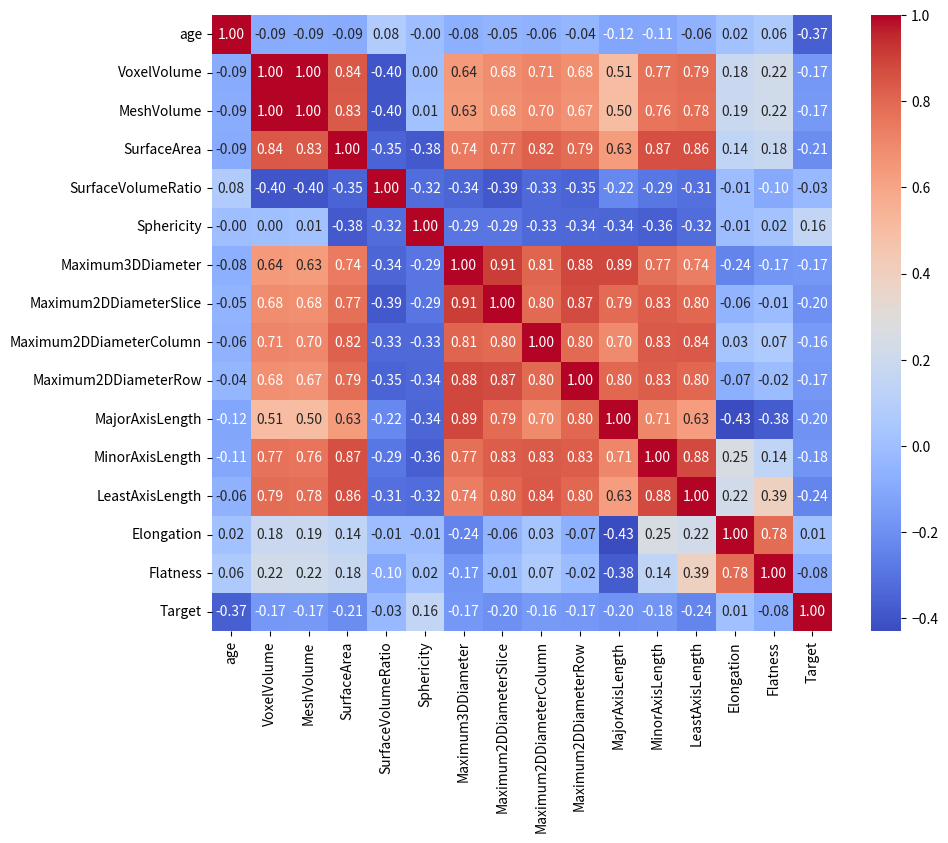

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt






x_train_df = pd.DataFrame(X_train, columns=['age','VoxelVolume', 
                        'MeshVolume', 'SurfaceArea', 'SurfaceVolumeRatio',# 'Compactness1', 'Compactness2', 'SphericalDisproportion',
                        'Sphericity', 
                        'Maximum3DDiameter','Maximum2DDiameterSlice','Maximum2DDiameterColumn','Maximum2DDiameterRow', 
                        'MajorAxisLength', 'MinorAxisLength', 'LeastAxisLength', 'Elongation', 'Flatness'])
y_train_df = pd.DataFrame({'Target': y_train})  

print(x_train_df)

data = pd.concat([x_train_df, y_train_df], axis=1)


correlation_matrix = data.corr()


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 10})
plt.title('')
plt.savefig('correlation_matrix.png', bbox_inches='tight')
plt.show()



In [6]:
correlations = data.corr()['Target'].abs().sort_values(ascending=False)
print(correlations)

Target                     1.000000
age                        0.368303
LeastAxisLength            0.238652
SurfaceArea                0.210332
Maximum2DDiameterSlice     0.195947
MajorAxisLength            0.195084
MinorAxisLength            0.181583
Maximum3DDiameter          0.170944
Maximum2DDiameterRow       0.169125
VoxelVolume                0.168530
MeshVolume                 0.166710
Maximum2DDiameterColumn    0.161387
Sphericity                 0.155664
Flatness                   0.083848
SurfaceVolumeRatio         0.027307
Elongation                 0.010644
Name: Target, dtype: float64


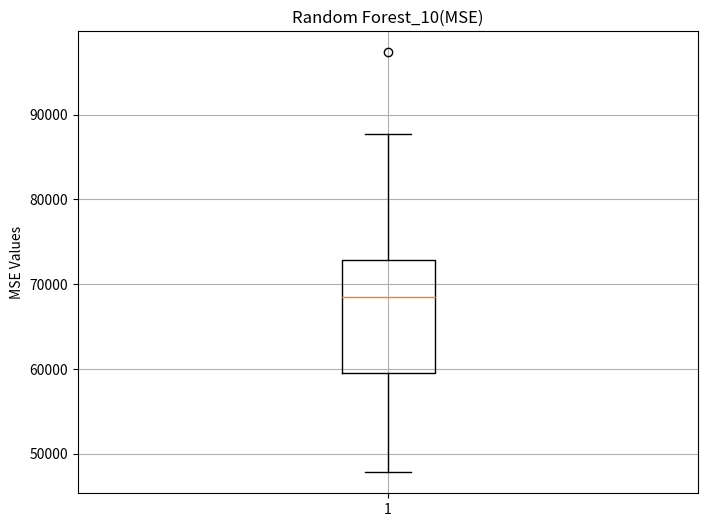

In [7]:

# Example list of 20 MSE values (replace this with your actual MSE values)
mse_values = np.random.uniform(low=0.1, high=1.0, size=20)  # Generating random MSE values for demonstration

# Creating a box plot for MSE values
plt.figure(figsize=(8, 6))
plt.boxplot(m)
plt.title('Random Forest_10(MSE)')
plt.ylabel('MSE Values')
plt.grid(True)
plt.show()

